In [19]:
import music21 as m21
from music21 import * 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from collections import Counter


In [20]:
def shuukei(vocalpart):
    """
    音価・音高のペアのオブジェクトを楽譜から作る
    タイの部分→連結

    """
    record = []
    checker = False
    #タイがついた場合の途中記録用
    pitch_tmp = 0.0
    duration_tmp = 0.0
    for i in vocalpart.flat.notesAndRests.stream():
        
        #タイがついている
        if i.tie:
            #タイのはじめの音ならまず音高を記録する
            if checker == False:
                if i.isNote == True:
                    #record.append([i.pitch.ps,i.duration.quarterLength])
                    #音符はノート番号
                    pitch_tmp = i.pitch.ps
                    duration_tmp += i.duration.quarterLength
                elif i.isRest == True:
                    #record.append(["rest",i.duration.quarterLength])
                    #休符は無限にする
                    pitch_tmp = np.inf
                    duration_tmp += i.duration.quarterLength
                
            #タイの途中の音なら音長を足していく      
            else:
                duration_tmp += i.duration.quarterLength
            
            #タイはついている   
            checker = True
        
        #タイがついてない    
        else:
            checker = False
            #直前がタイの最後の音ならタイでつながって一音になった音を追加
            if not duration_tmp == 0.0:
                record.append([pitch_tmp,duration_tmp])
                duration_tmp = 0.0
            
            #そうでなければ普通に追加
            if i.isNote == True:
                record.append([i.pitch.ps,i.duration.quarterLength])
            elif i.isRest == True:
                record.append([np.inf,i.duration.quarterLength])

    return record

In [21]:
def count_duration(song):
    #[音高,音価]が要素になったリストから音価を集計する
    lis = []
    for n in range(len(song)):
        lis.append(song[n][1])
    duration_count = Counter(lis)
    #集計結果のカウンターを返す
    #sorted_count = sorted(duration_count.items(),key=lambda x:x[0])
    #return sorted_count
    
    return duration_count

In [22]:
def count_pitch(song):
    #[音高,音価]が要素になったリストから音高を集計する
    lis = []
    for n in range(len(song)):
        lis.append(song[n][0])
    pitch_count = Counter(lis)
    #集計結果のカウンターを返す
    return pitch_count

In [23]:
def make_pitch_bigram(shuukei_obj):
    #[音高,音価]が要素になったリストから音高のBigramのリストを作成する
    pitch_diff = []
    for i in range(len(shuukei_obj)-1):
        if shuukei_obj[i+1][0] > 10000 and shuukei_obj[i][0] > 10000:
        	pass
        else:
            pitch_diff.append(shuukei_obj[i+1][0] - shuukei_obj[i][0])
    return pitch_diff

In [24]:
def make_duration_bigram(shuukei_obj):
    #[音高,音価]が要素になったリストから音価のBigramのリストを作成する
    duration_diff = []
    for i in range(len(shuukei_obj)-1):
        duration_diff.append(shuukei_obj[i+1][1] - shuukei_obj[i][1])
    return duration_diff

In [25]:
def jump_rate(bigram_status):
    #バイグラム列から跳躍、下降跳躍、上向跳躍の割合を返す
    up_jump = 0
    down_jump = 0
    slope = 0 
    for key in bigram_status.keys():
        if np.abs(key) <= 2:
            slope += bigram_status[key]
        elif np.abs(key) <= 10000:
            if key > 0:
            	up_jump += bigram_status[key]
            else:
                down_jump += bigram_status[key]
    all_of_notes = up_jump + down_jump + slope
    
    return set((up_jump+down_jump)/all_of_notes,up_jump/all_of_notes,down_jump/all_of_notes)          

In [26]:
def delete_inf(bigram_status): 
    #休符を含むBigramから休符を削除
    del bigram_status[np.inf]
    del bigram_status[-np.inf]
    del bigram_status[None]
    return bigram_status

In [27]:
#Aメロ,Bメロ,サビに分割
#各セクションの始点と終点の小節番号を引数に与える
def separate_section(piece,a_start,a_end,b_start,b_end,s_start,s_end):
    sections = []
    amero = piece.measures(a_start,a_end)
    bmero = piece.measures(b_start,b_end)
    sabi = piece.measures(s_start,s_end)
        
    print(sabi)
    sections.append(amero)
    sections.append(bmero)
    sections.append(sabi)
    
    return sections

In [28]:
#カウンターオブジェクトのプロット
def counter_plot(counter,song,section,analysee_name,bar_color):
    left = counter.keys()
    height = counter.values()
    plt.title("song: {} ({}'s {})".format(song,section,analysee_name))
    plt.bar(left,height,color=bar_color)
    for x, y in zip(left, height):
        try: 
            plt.text(x, y, y, ha='center', va='bottom')
        except ValueError: 
            pass 
    plt.grid()
    plt.show()

In [29]:
#音高、音価のペアのリストをセクションごとに作成
def make_note(sections):
    notes = []
    for item in sections:
        note_obj = shuukei(item) 
        notes.append(note_obj)
    return notes

In [30]:
#セクションごとに音高、音価のペア列から音程列を作成
def make_pitch_diff(notes):
    ontei = []
    for item in notes:
        bigram = make_pitch_bigram(item)
        onteiobj = delete_inf(Counter(bigram))
        ontei.append(onteiobj)
    return ontei

## 予備実験概要

実験参加者数　6人（21～24歳の男子６人、内音楽経験あり３人）
実施楽曲　6曲＋α


In [35]:
analysis_corpus = []
analysis_section = {0:"A melody",1:"B melody",2:"Sabi"}

## テストコード

#楽譜の読み込み
cherry = m21.converter.parse("./cherry.xml").parts[0]
#各セクションに分ける
cherry_section = []
cherry_a = cherry.measures(1,8)
cherry_b = cherry.measures(9,16)
cherry_s = cherry.measures(16,24)

cherry_section.append(cherry_a)
cherry_section.append(cherry_b)
cherry_section.append(cherry_s)
#音高,音価の列のオブジェクトを作成
cherry_section_notes = []
for item in cherry_section:
    notes = shuukei(item)
    cherry_section_notes.append(notes)
#音高Bigramを作成
cherry_ontei = []
for item in cherry_section_notes:
    bigram = make_pitch_bigram(item)
    onteiobj = delete_inf(Counter(bigram))
    cherry_ontei.append(onteiobj)
#音高差の集計をプロット
for num,item in enumerate(cherry_ontei):
    counter_plot(item,"cherry",str(analysis_section[num]),"pitch_diff")
#音高の集計
for item in cherry_section:
    item.plot("histogram","pitch")
    item.plot("histogram","pitchclass") 

for num,item in enumerate(cherry_section_notes):
    dcount = count_duration(item)
    #print(dcount)
    duras = {}
    for i in sorted(dcount.keys()):
        new_key = str(i)
        duras[new_key] = dcount[i]
    counter_plot(duras,"cherry",str(analysis_section[num]),"duration by Quarter Length")
#調,音符数,跳躍率
analysis_section = {0:"Amelody",1:"Bmelody",2:"Sabi"}
print(len(cherry))
print(analysis.discrete.analyzeStream(cherry,"Krumhansl"))
for num,section in enumerate(cherry_section):
    print(section)
    print("-------{}の統計情報---------".format(analysis_section[num]))
    print("調:{}".format(analysis.discrete.analyzeStream(section,"Krumhansl")))

In [51]:
class gakuhu_object:
    """
    ボーカルパートのあらゆる情報を保持するクラス
    
    __init__(self,file)　
    初期化、読み込む楽譜ファイルを与える
    
    separate_section(self,a_start,a_end,b_start,b_end,s_start,s_end) 
    A,B,サビに楽譜を分割、それぞれのセクションの始めの小節と終わりの小節の番号を与える
    """
    
    #コンストラクタ
    def __init__(self,name,file,separate_info):
        #楽曲名
        self.name = name
        #ボーカルパートを読み込み（一つ目のパートがボーカルである前提・・・）
        self.piece = m21.converter.parse("./" + file).parts[0]
        #Aメロ、Bメロ、サビのオブジェクトを保持する
        self.sections = separate_section(self.piece,separate_info[0],separate_info[1],separate_info[2],separate_info[3],separate_info[4],separate_info[5])
        #音高、音列のペア
        self.notes = make_note(self.sections)
        #音程列
        self.ontei = make_pitch_diff(self.notes)
        
        analysis_corpus.append(self)
        
    #調の表示
    def show_key(self):
        print("------------"+self.name +"-------------")
        for num,section in enumerate(self.sections):
            print("-------{}の統計情報---------".format(analysis_section[num]))
            print("調:{}".format(analysis.discrete.analyzeStream(section,"Krumhansl")))
    """
    #音高、音価のペアのリストをセクションごとに作成
    def make_note(self):
        for item in self.sections:
            note_obj = shuukei(item) 
            self.notes.append(note_obj)
    
    #音程列の作成
    def make_pitch_diff(self):
        for item in self.notes:
            bigram = make_pitch_bigram(item)
            onteiobj = delete_inf(Counter(bigram))
            self.notes.append(onteiobj)
    """    
    #音高のカウント
    def counting_pitch(self):
        for item in self.sections:
            pitch_space = graph.plot.HistogramPitchSpace(item,xHideUnused=False)
            pitch_space.colors = "magenta"
            pitch_space.run()
            pitch_class = graph.plot.HistogramPitchClass(item,xHideUnused=False)
            pitch_class.colors = "cyan"
            pitch_class.run()
            #item.plot("histogram","pitch",xHideUnused=False)
            #item.plot("histogram","pitchclass",xHideUnused=False) 
        
    #音価のカウント
    def counting_duration(self):
        for num,item in enumerate(self.notes):
            dcount = count_duration(item)
            #print(dcount)
            duras = {}
            for i in sorted(dcount.keys()):
                new_key = str(i)
                duras[new_key] = dcount[i]
            counter_plot(duras,self.name,str(analysis_section[num]),"duration by Quarter Length","g")
            
    #音高差の集計をプロット
    def plot_pitch_diff(self):
        for num,item in enumerate(self.ontei):
            counter_plot(item,self.name,str(analysis_section[num]),"pitch_diff","r")
        
    #跳躍進行の割合を表示        
    def calucurate_jump(self):
        for sect in self.notes:
            jump_status = jump_rate(sect)
            print(jump_status)


## 実際に6曲分、分析してみる



In [52]:
analysis_corpus = []
cherry = gakuhu_object("Cherry","cherry.xml",[1,8,9,15,16,24])
tsunami = gakuhu_object("TSUNAMI","TSUNAMI.xml",[1,16,17,25,25,42])
roman = gakuhu_object("Roman Hikou","roman.xml",[1,8,9,16,16,29])
aporo = gakuhu_object("Aporo","aporo3.xml",[20,34,35,43,44,59])
guren = gakuhu_object("Guren No Yumiya","guren.mxl",[12,27,28,35,36,51])
konayuki = gakuhu_object("Konayuki","konayuki.mxl",[5,26,27,37,37,45])


<music21.stream.Part トラック 0>
<music21.stream.Part ピアノ>
<music21.stream.PartStaff P1-Staff1>
<music21.stream.Part ボーカル>
<music21.stream.Part ボーカル>
<music21.stream.Part Lead>


------------Cherry-------------
-------A melodyの統計情報---------
調:d minor
-------B melodyの統計情報---------
調:a minor
-------Sabiの統計情報---------
調:C major


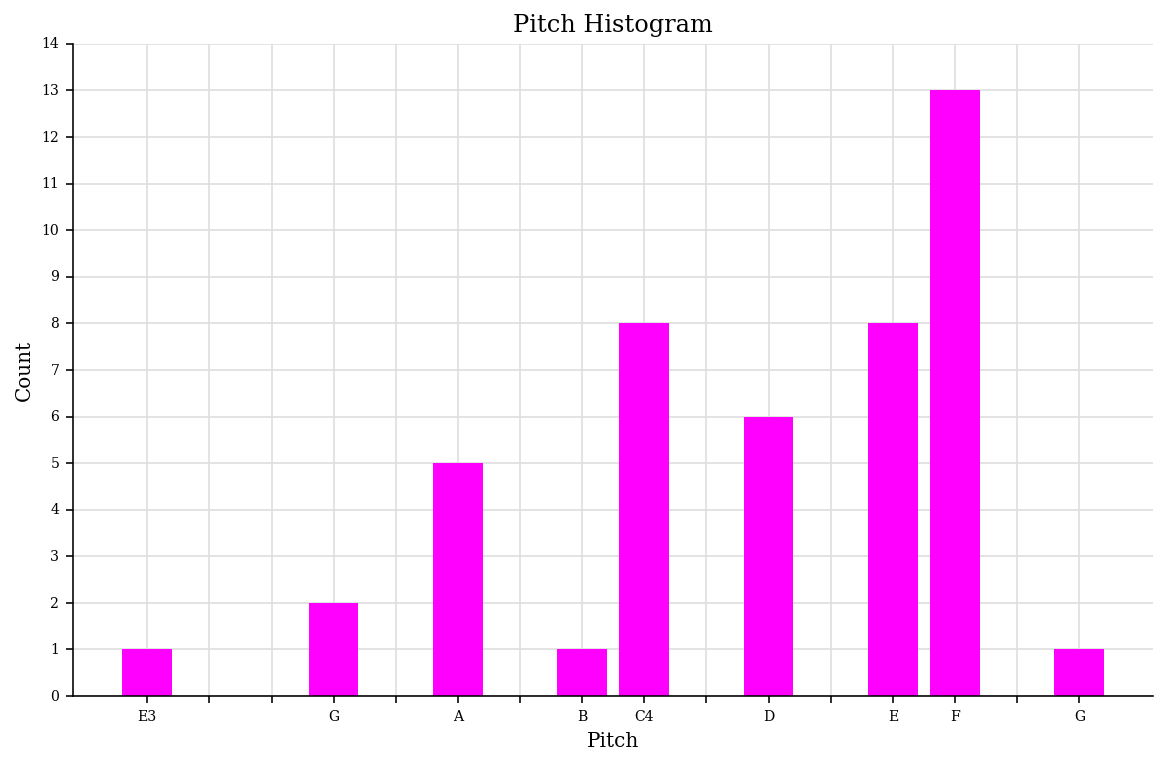

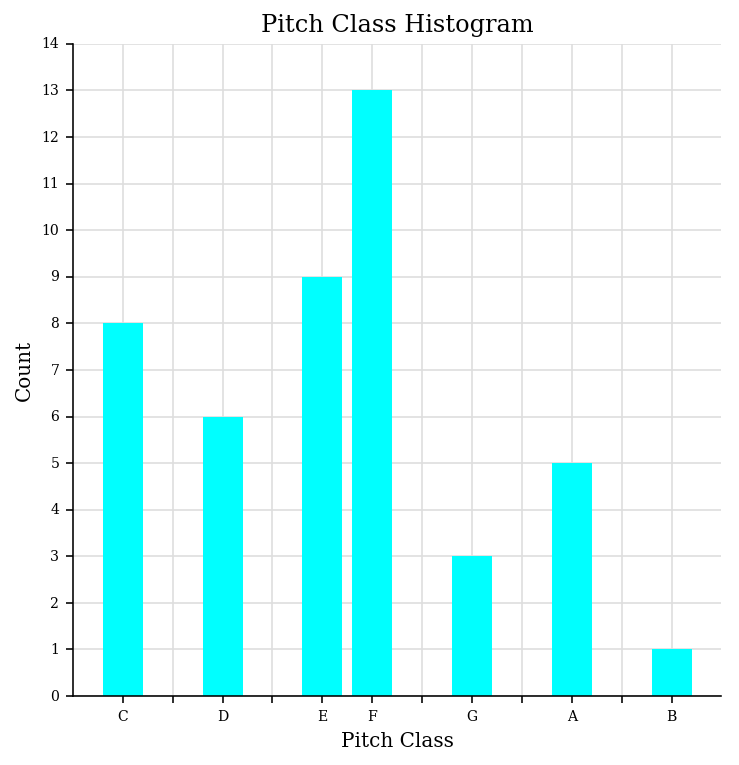

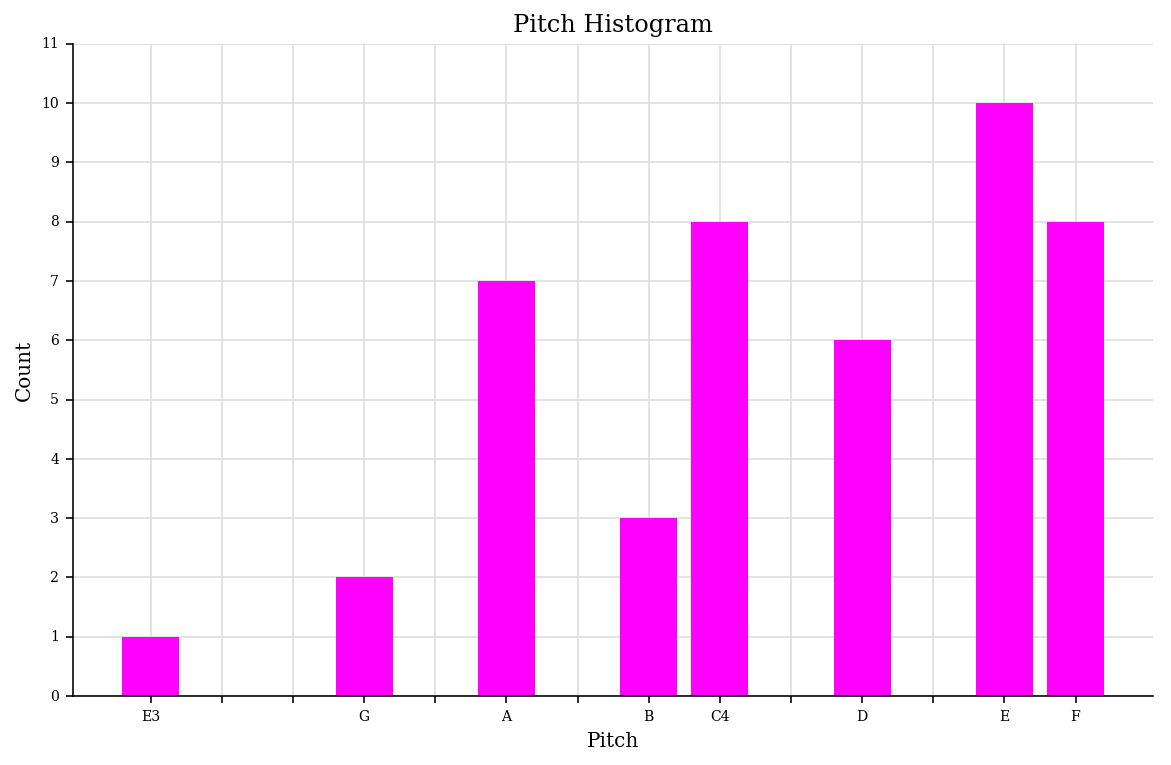

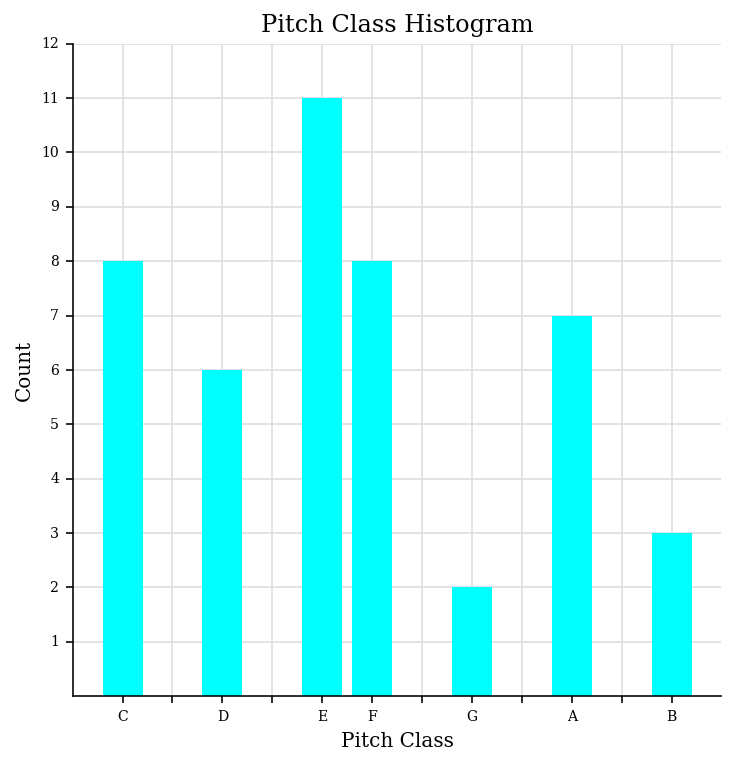

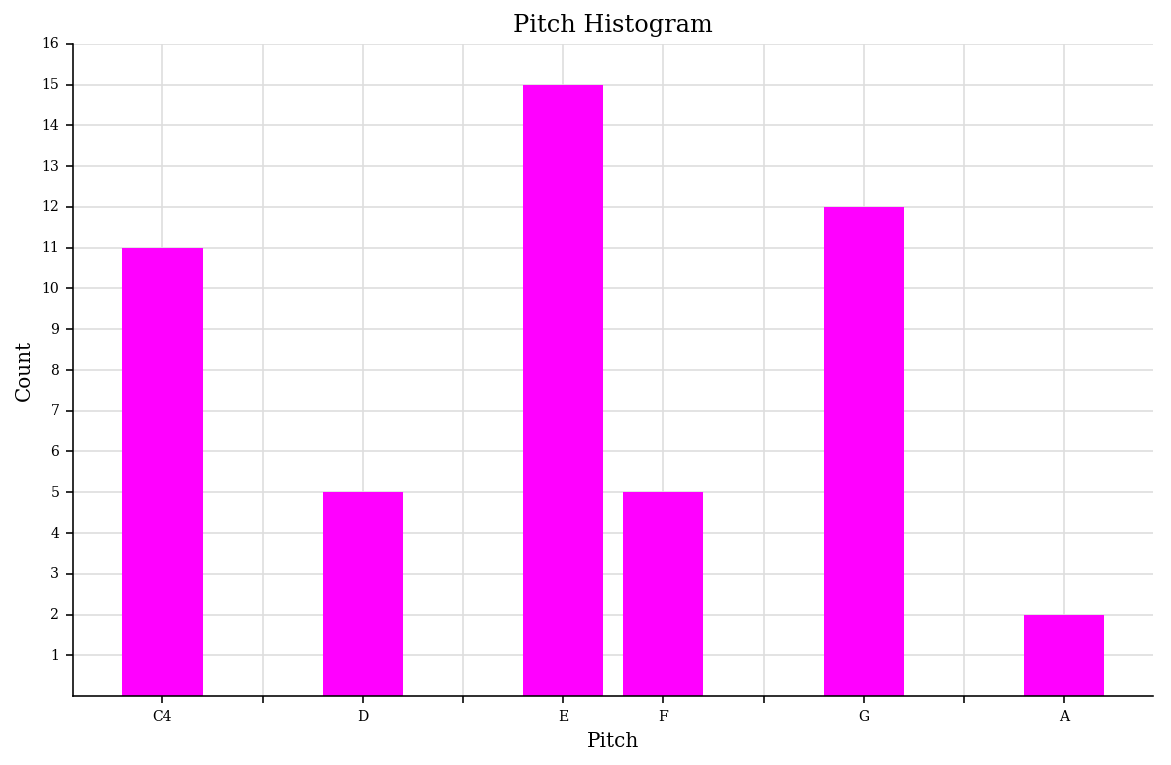

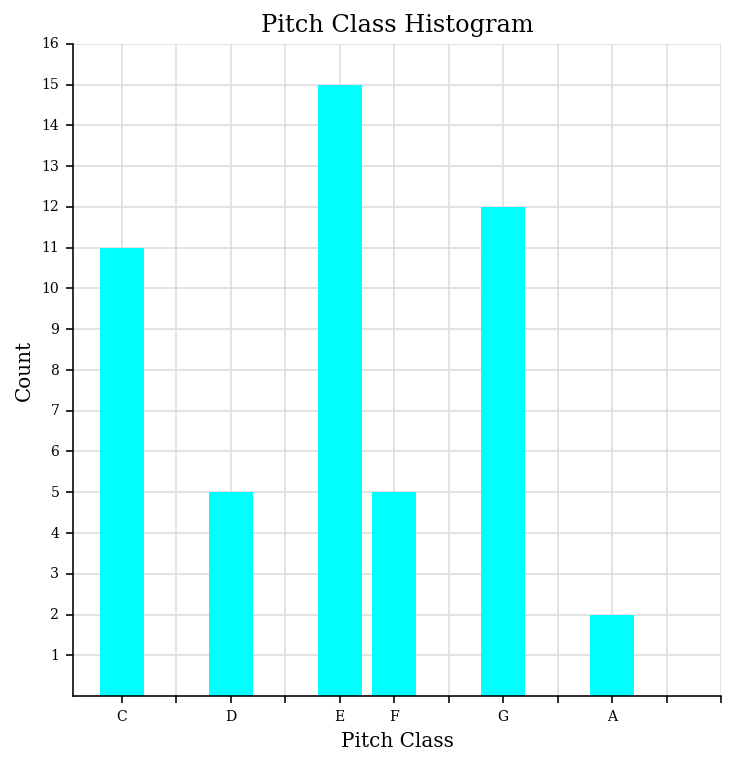

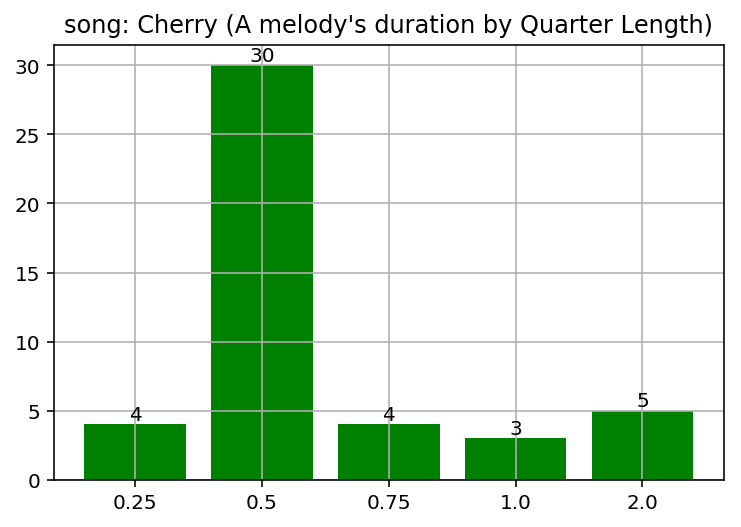

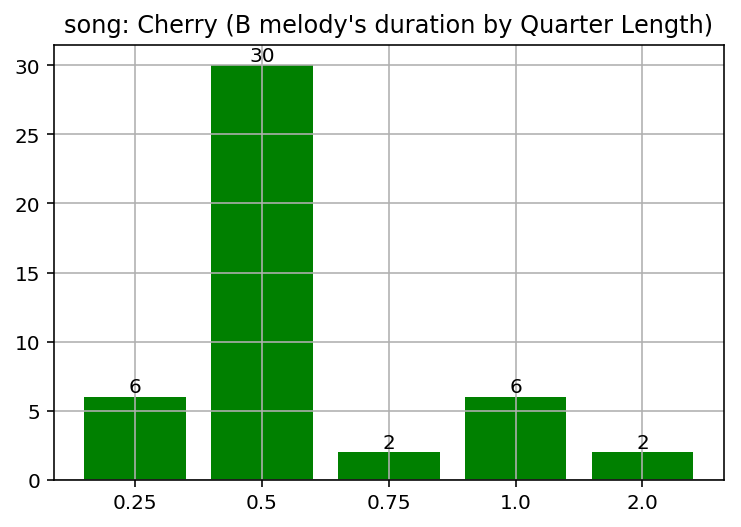

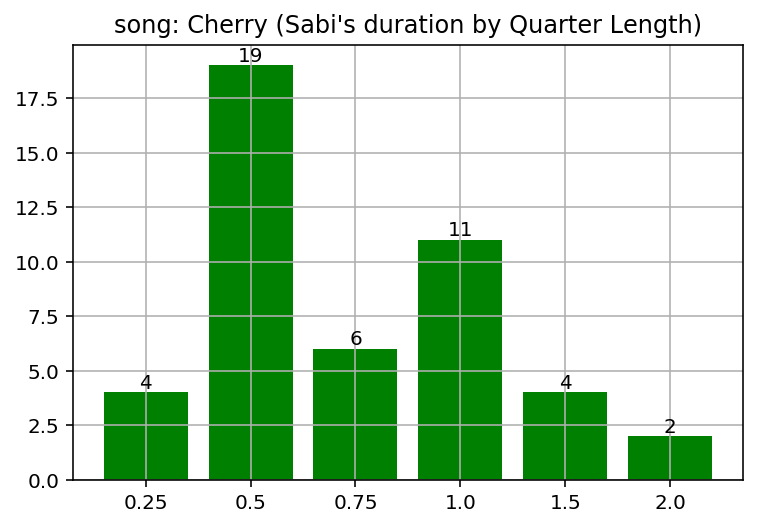

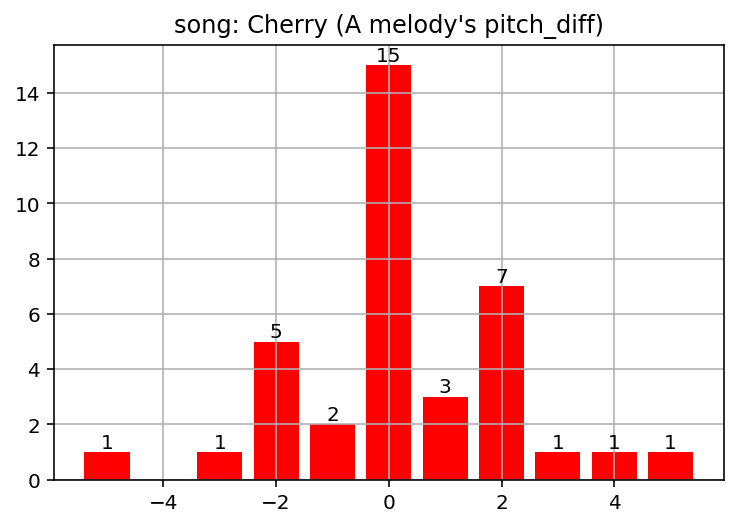

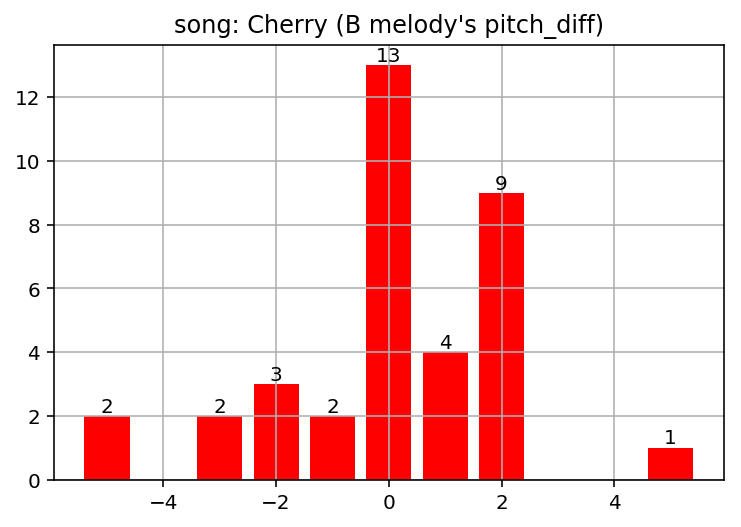

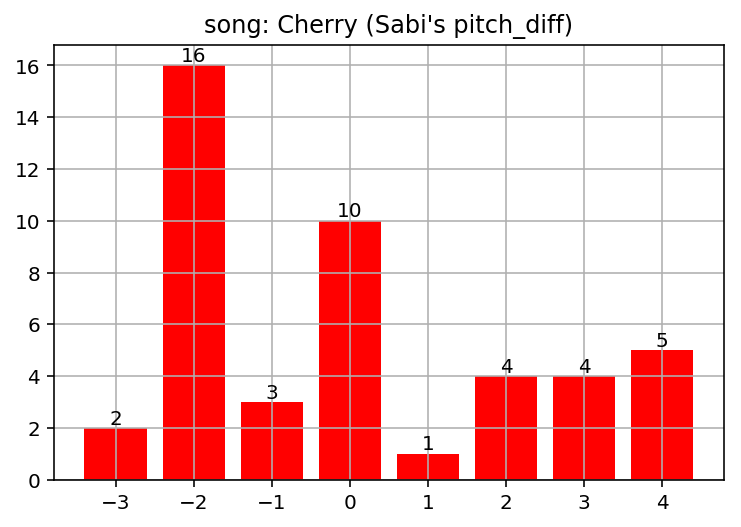

------------TSUNAMI-------------
-------A melodyの統計情報---------
調:D major
-------B melodyの統計情報---------
調:D major
-------Sabiの統計情報---------
調:D major


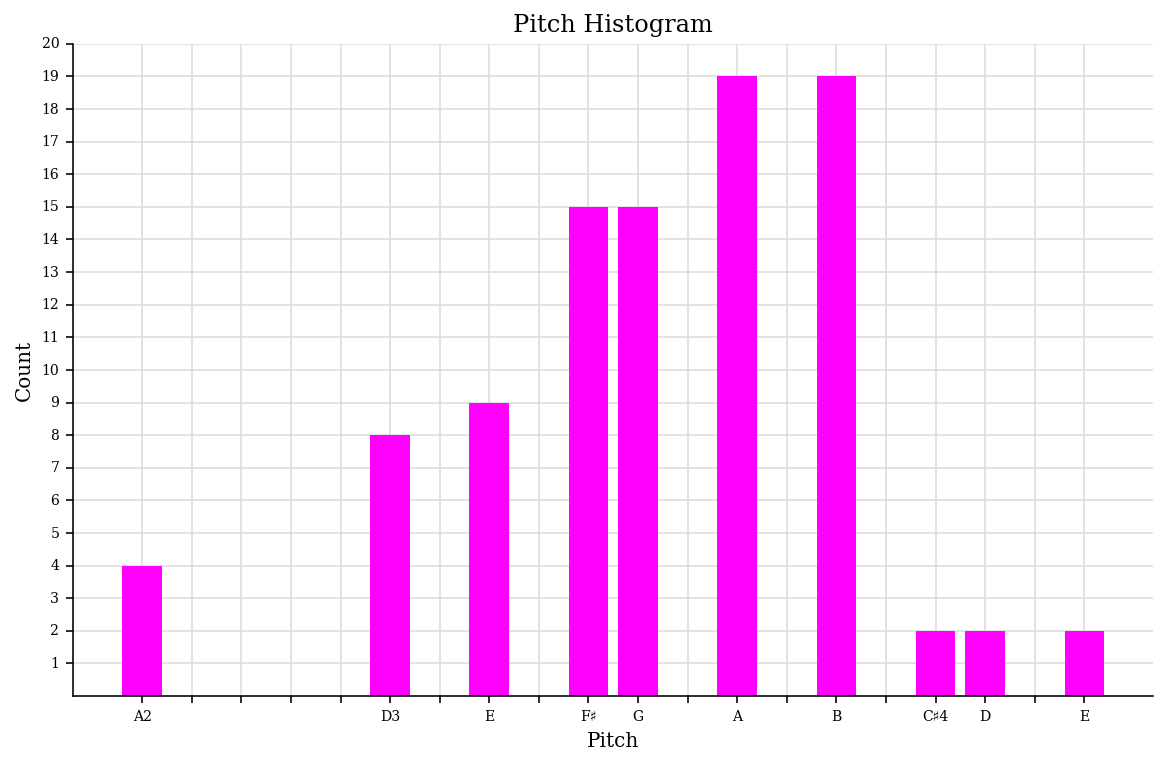

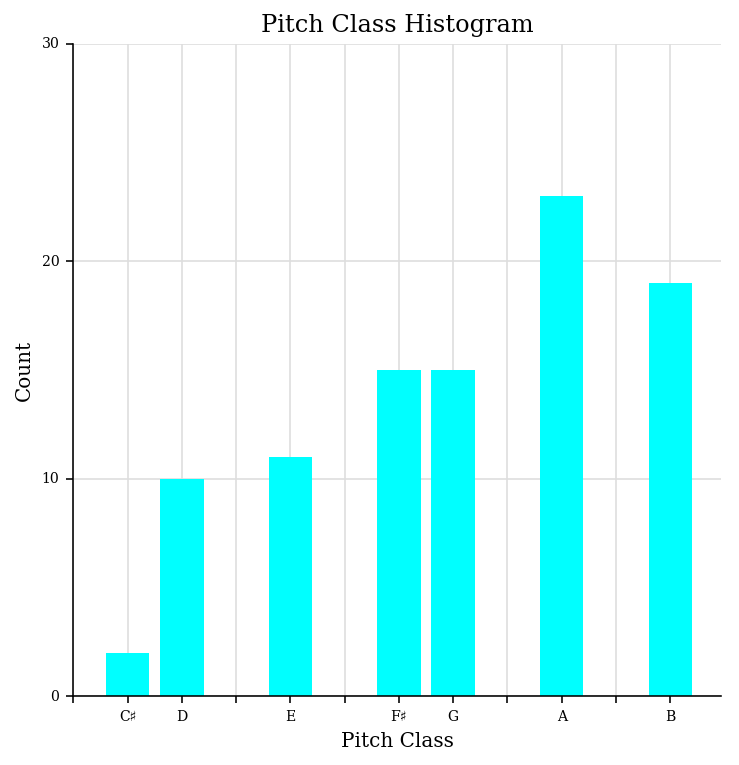

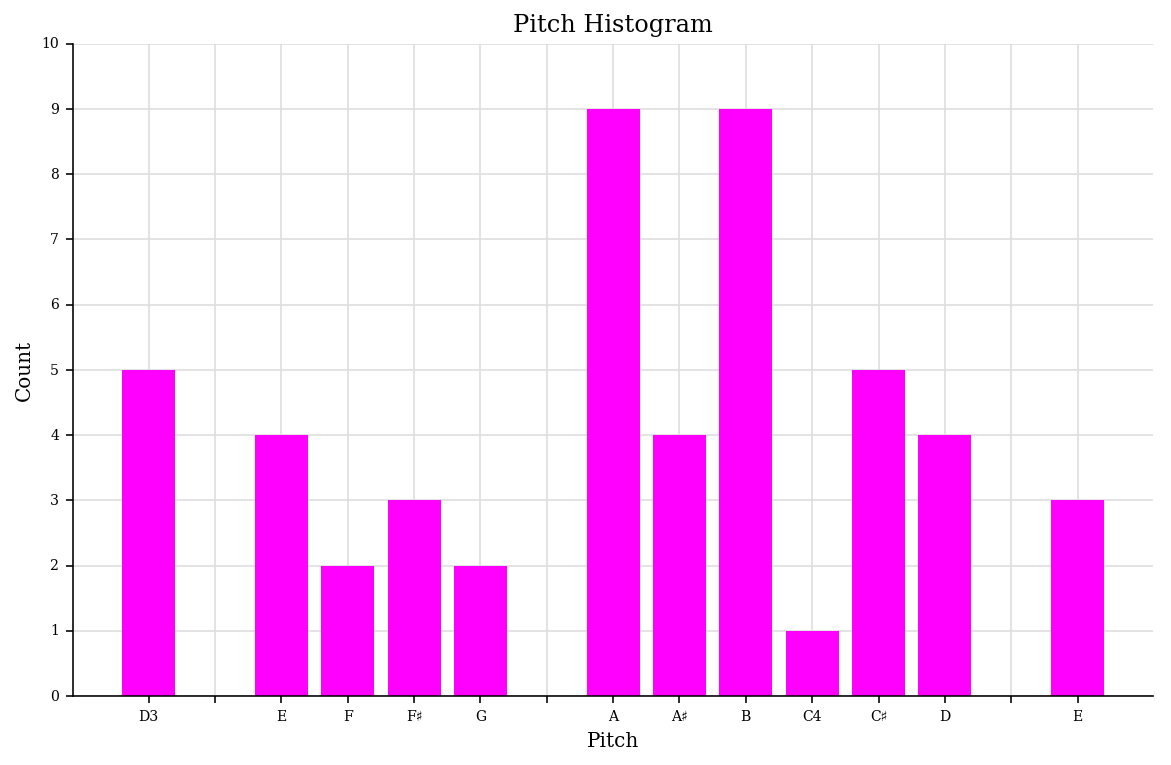

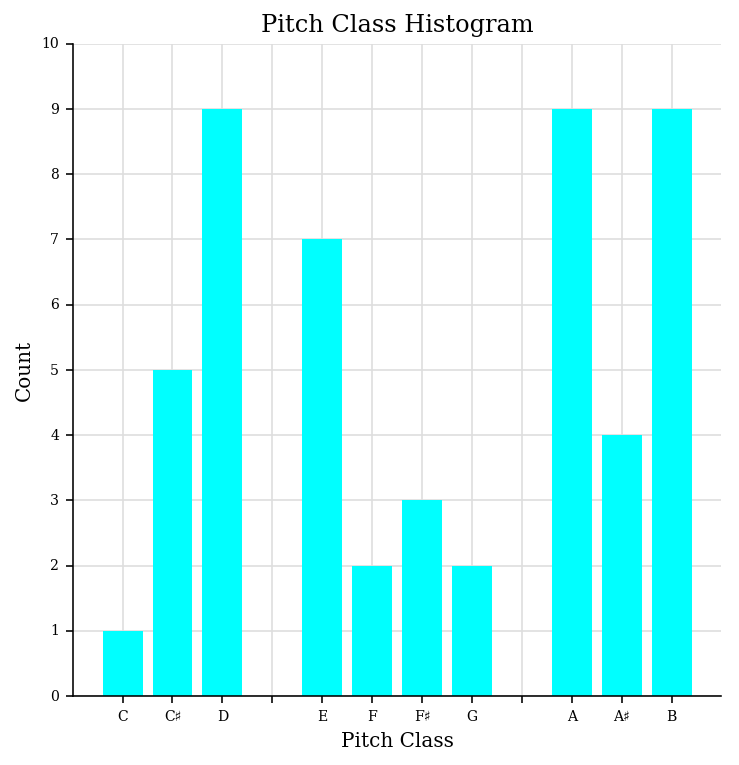

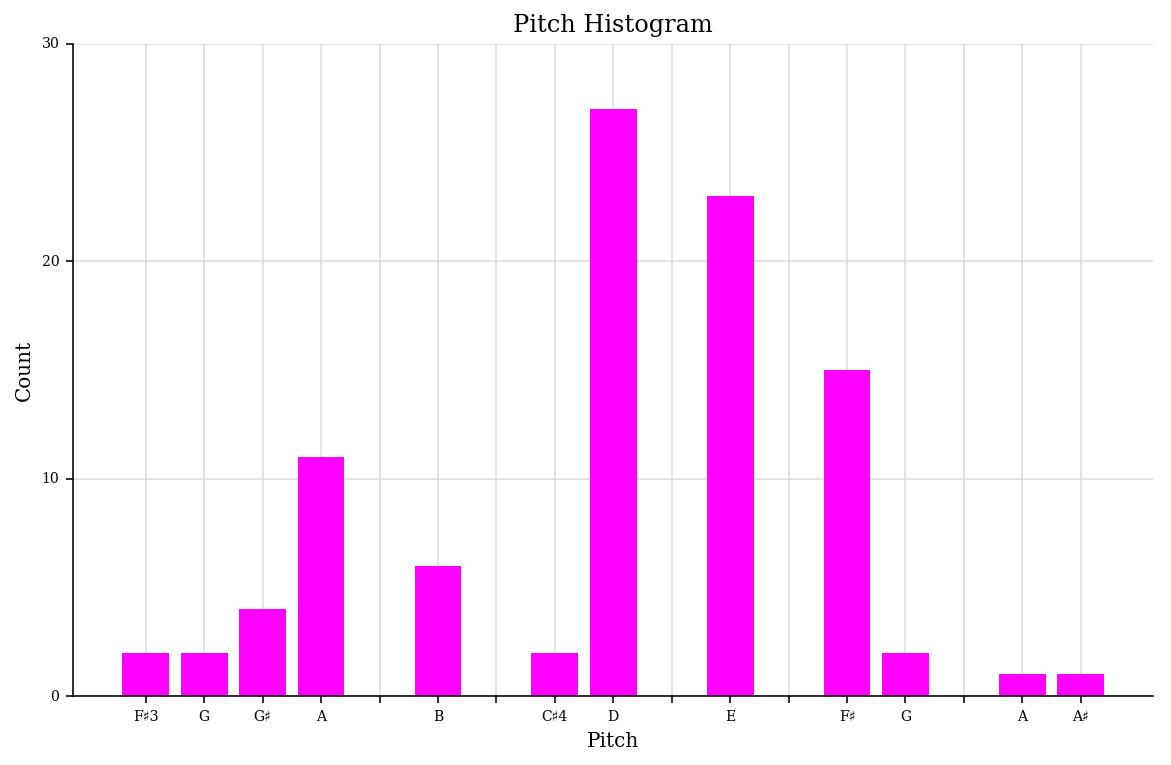

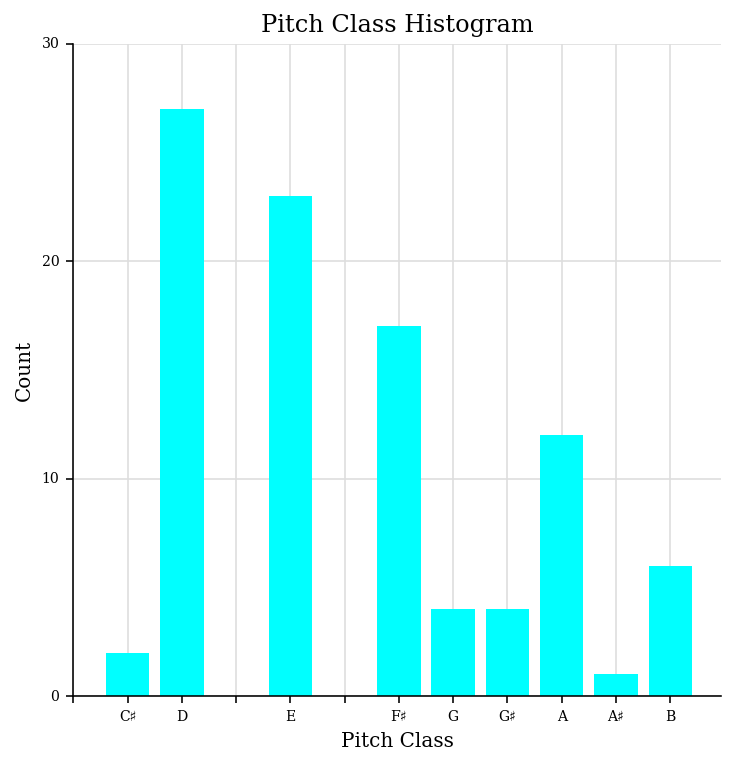

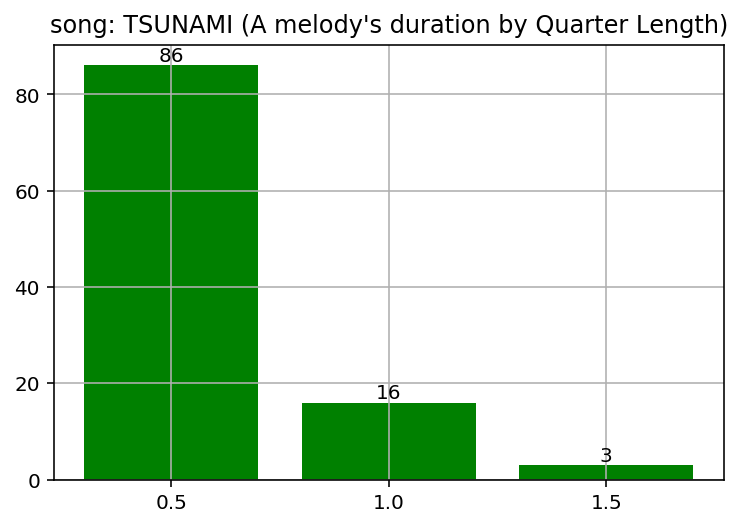

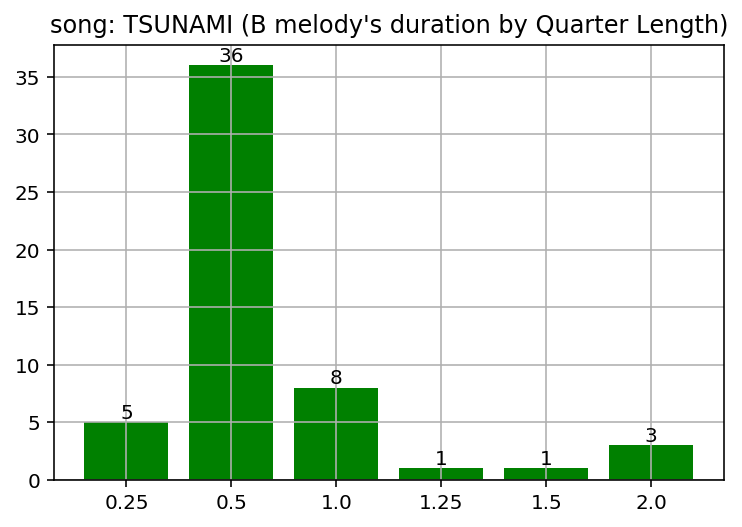

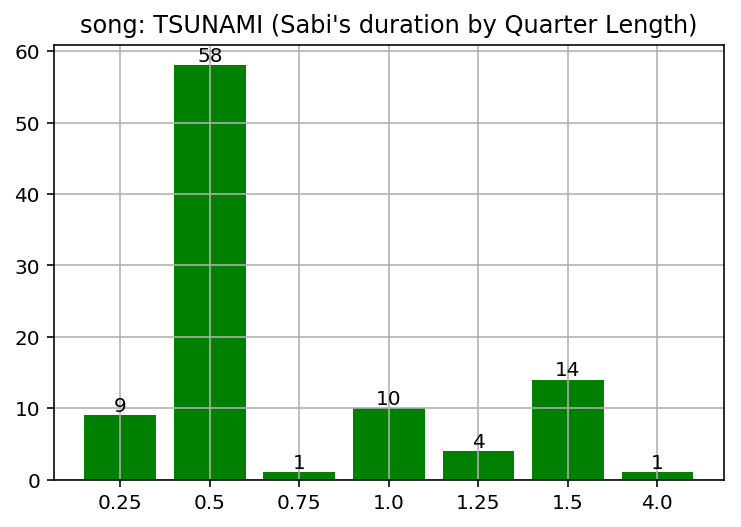

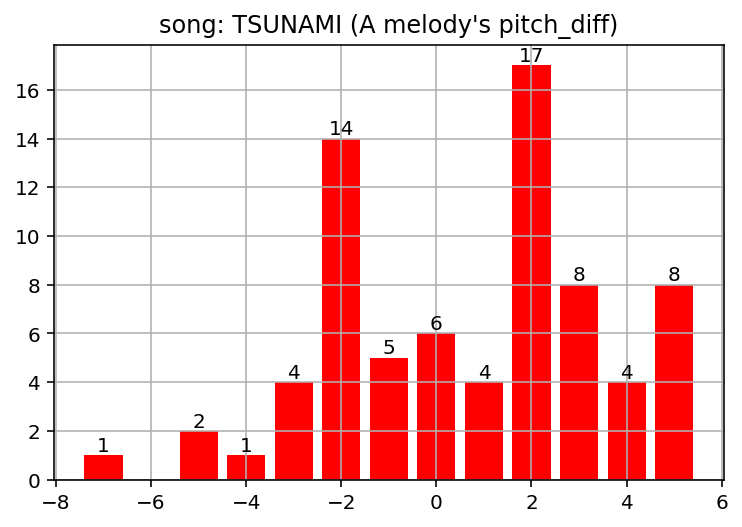

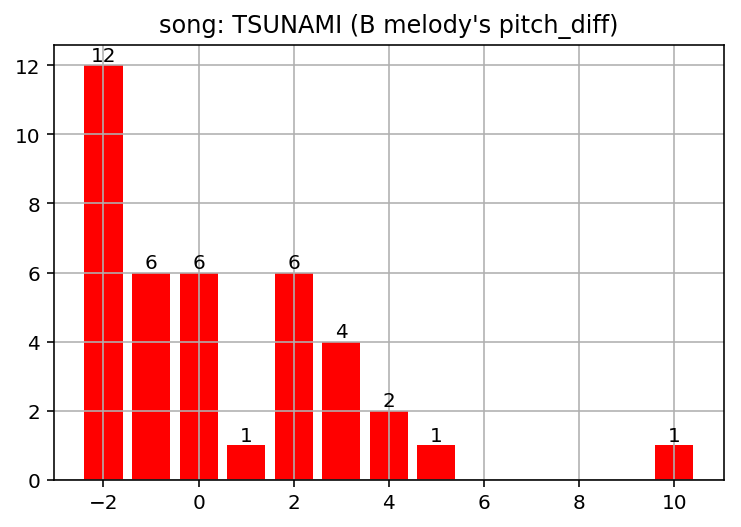

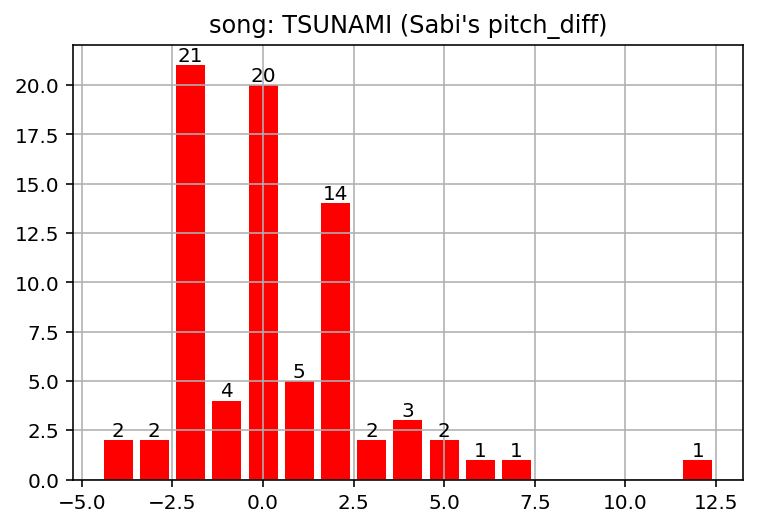

------------Roman Hikou-------------
-------A melodyの統計情報---------
調:B major
-------B melodyの統計情報---------
調:g# minor
-------Sabiの統計情報---------
調:B major


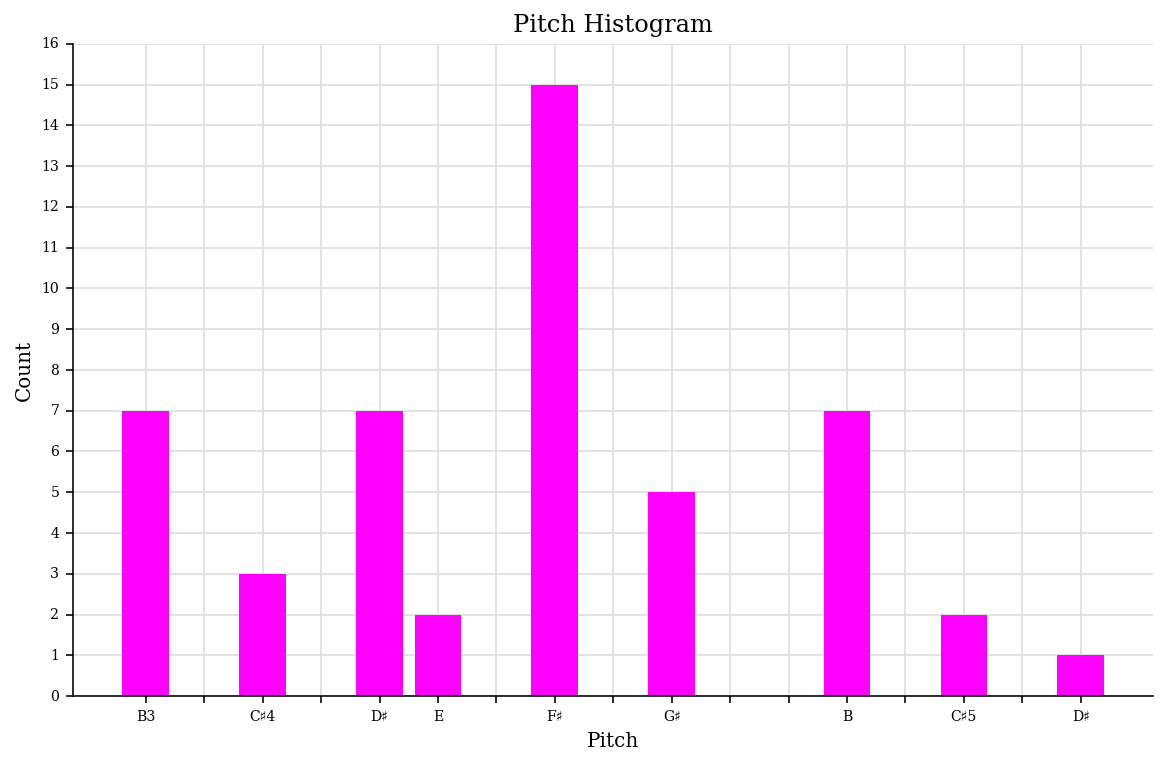

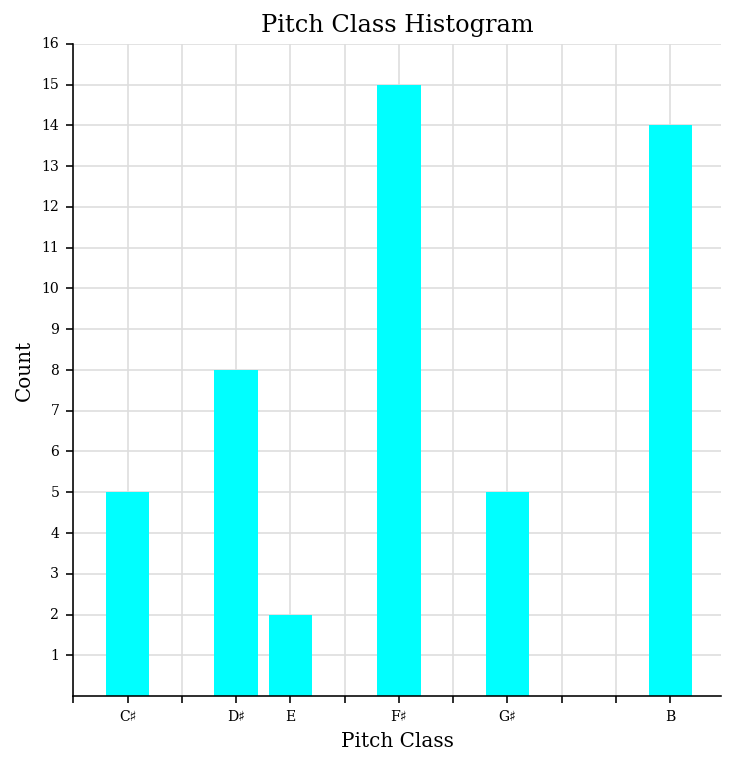

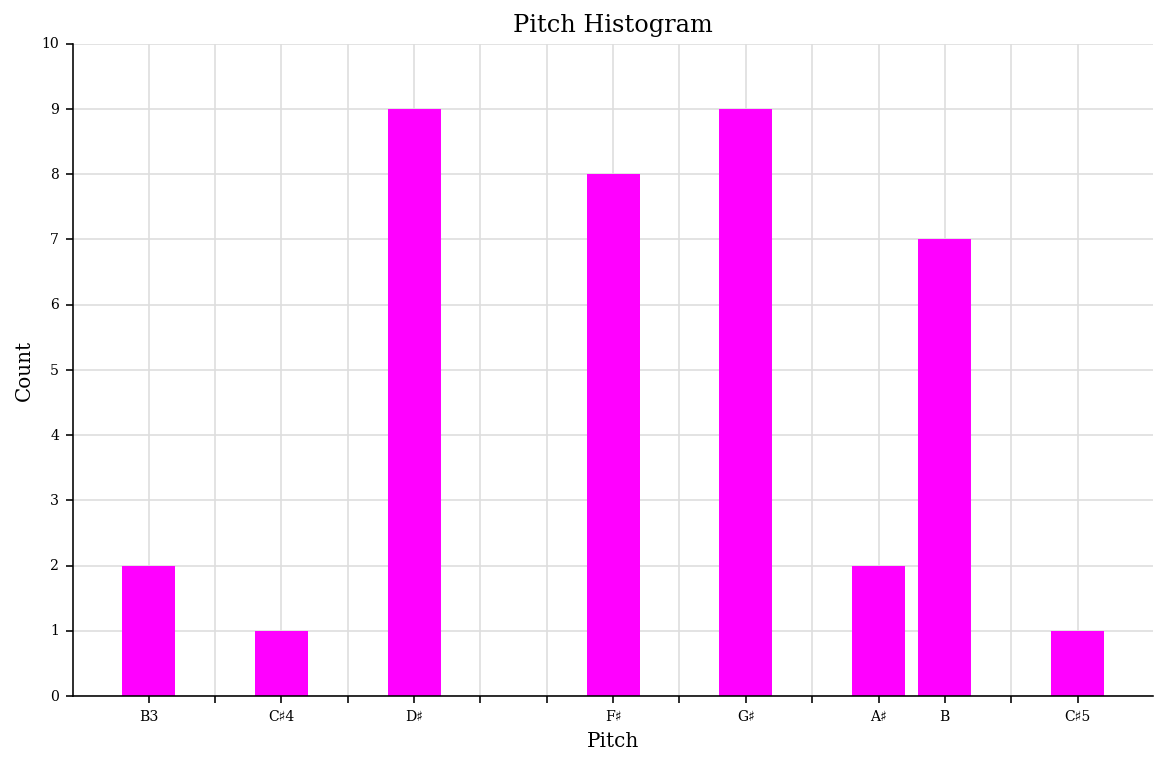

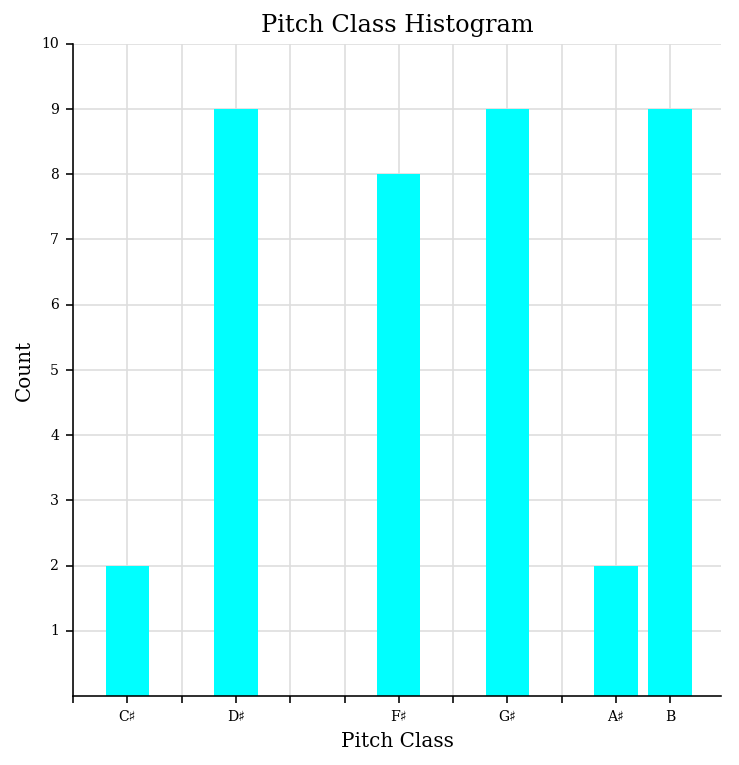

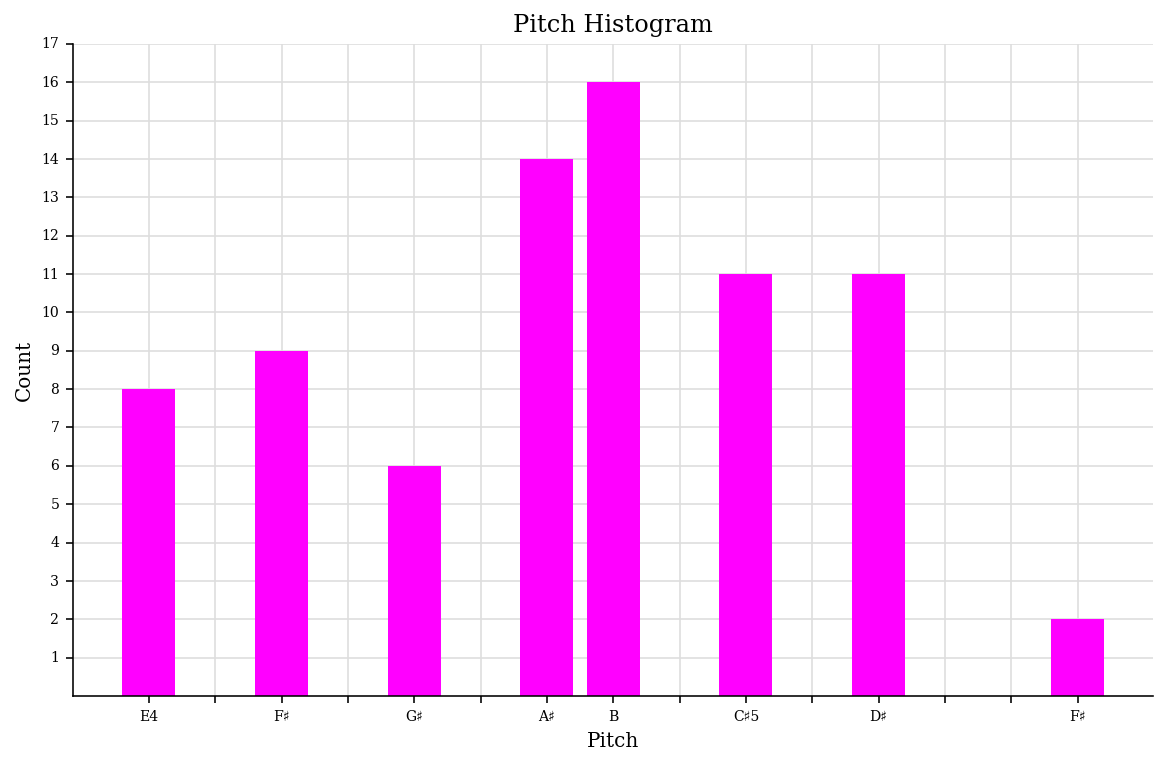

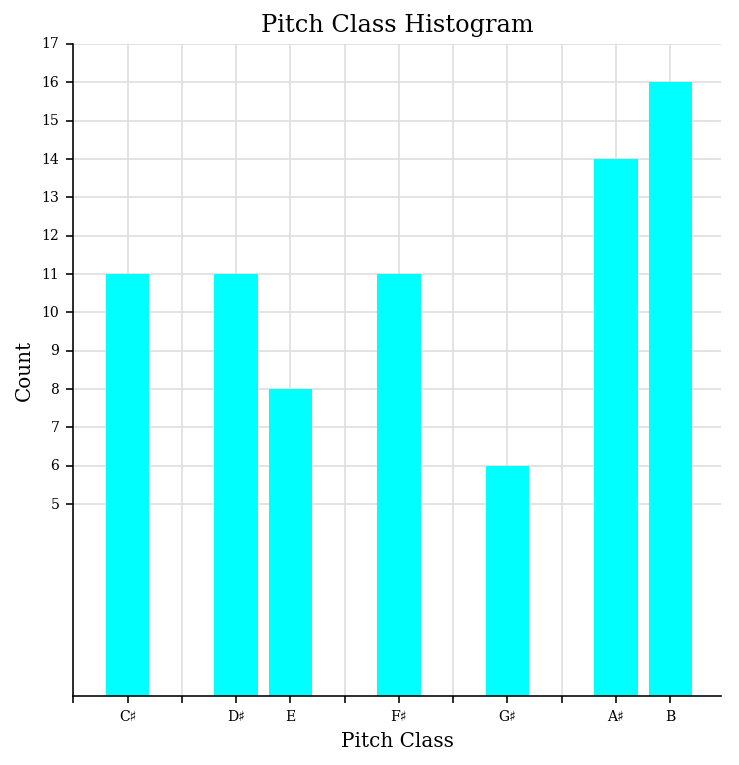

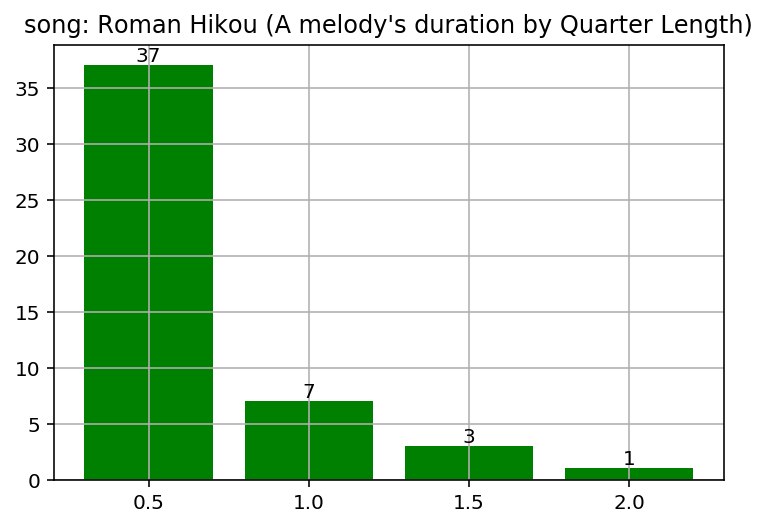

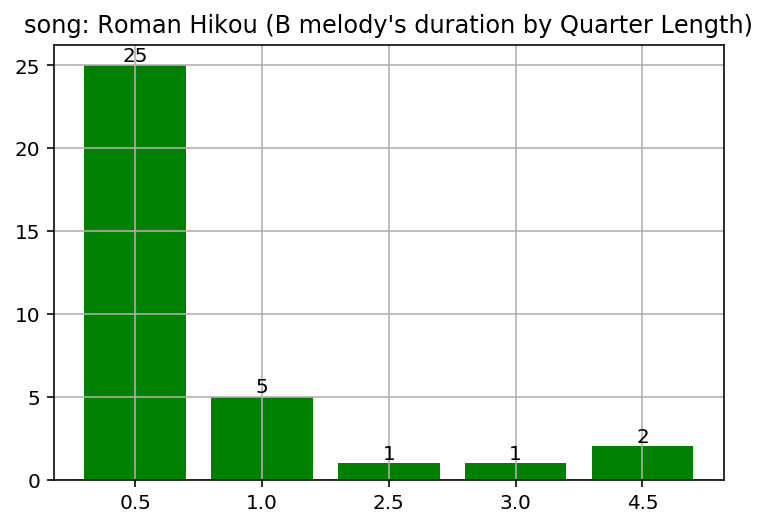

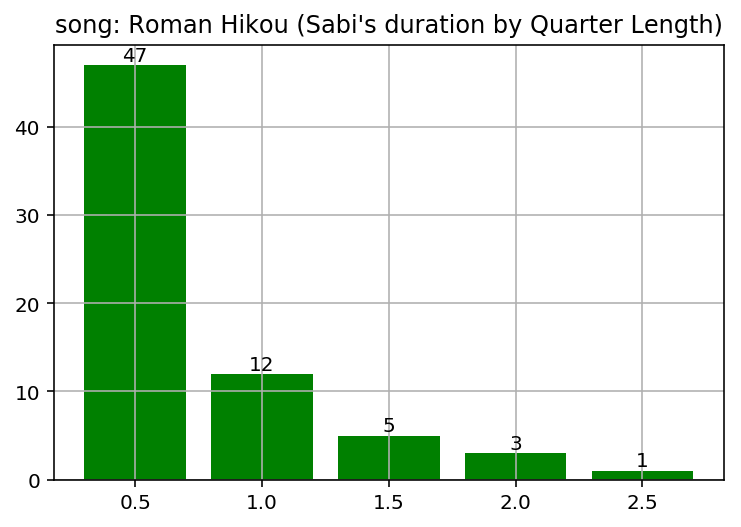

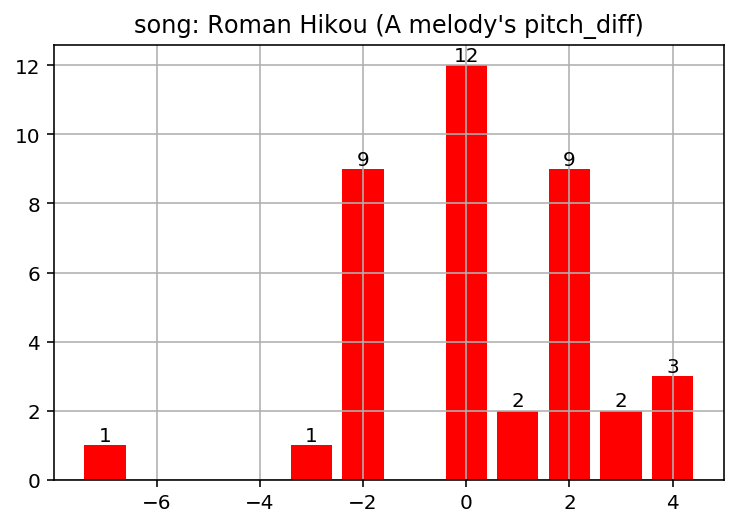

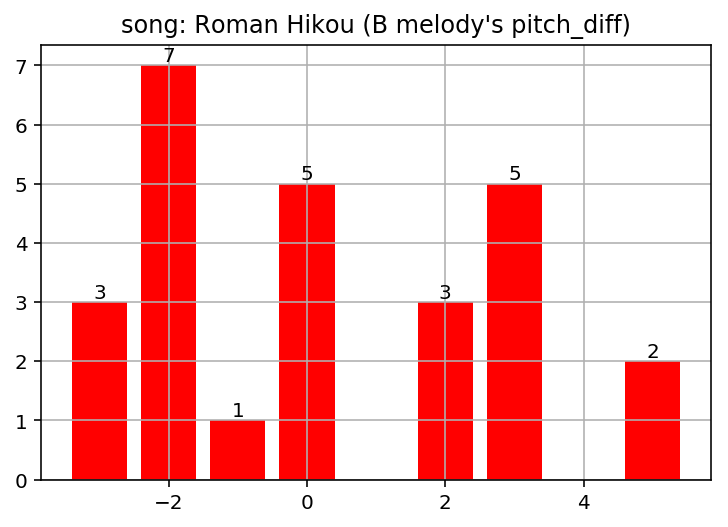

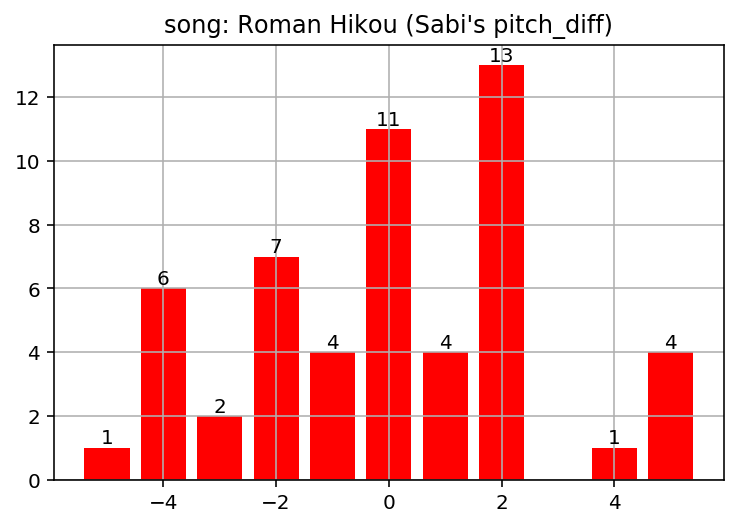

------------Aporo-------------
-------A melodyの統計情報---------
調:e minor
-------B melodyの統計情報---------
調:e minor
-------Sabiの統計情報---------
調:e minor


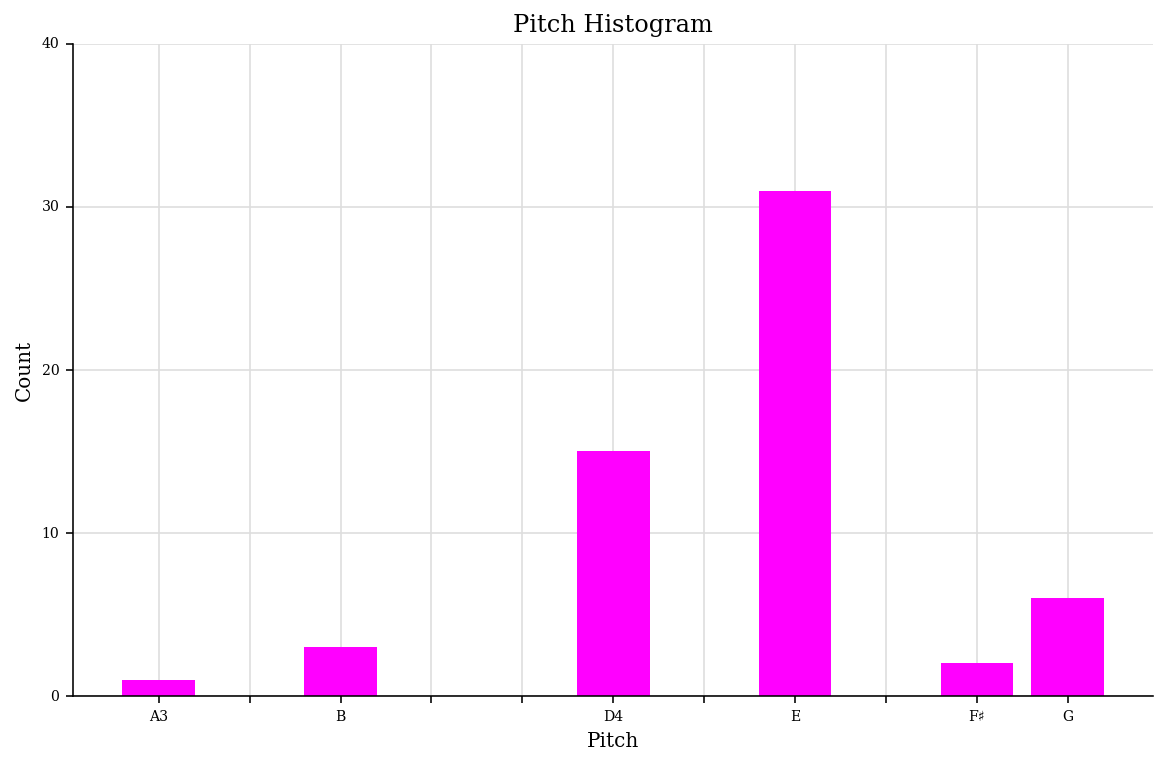

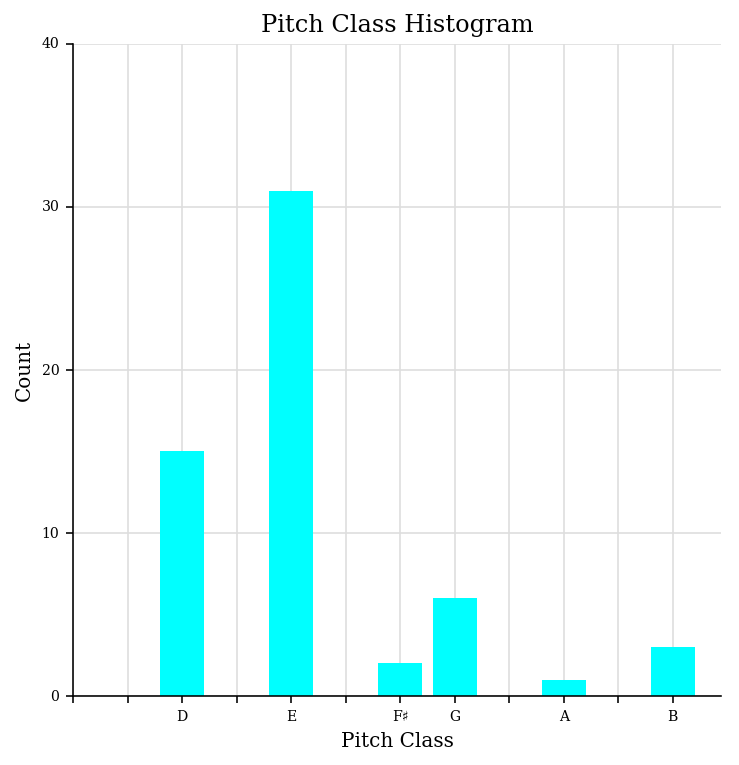

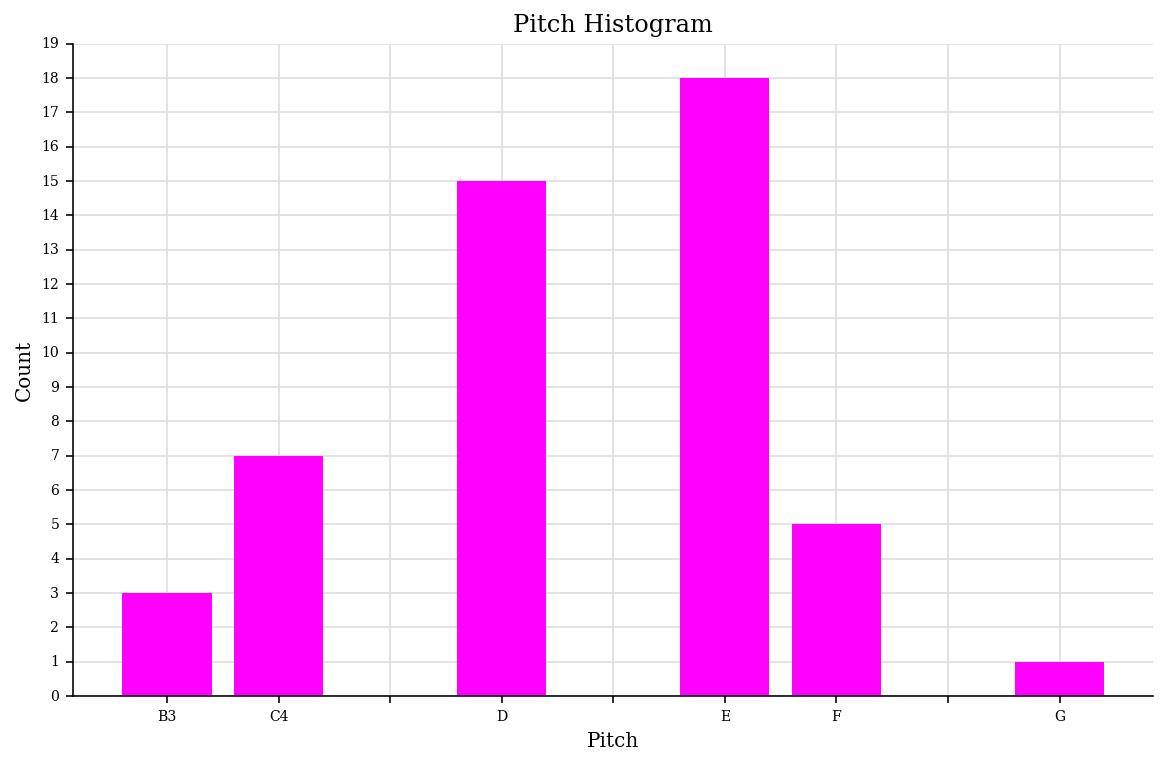

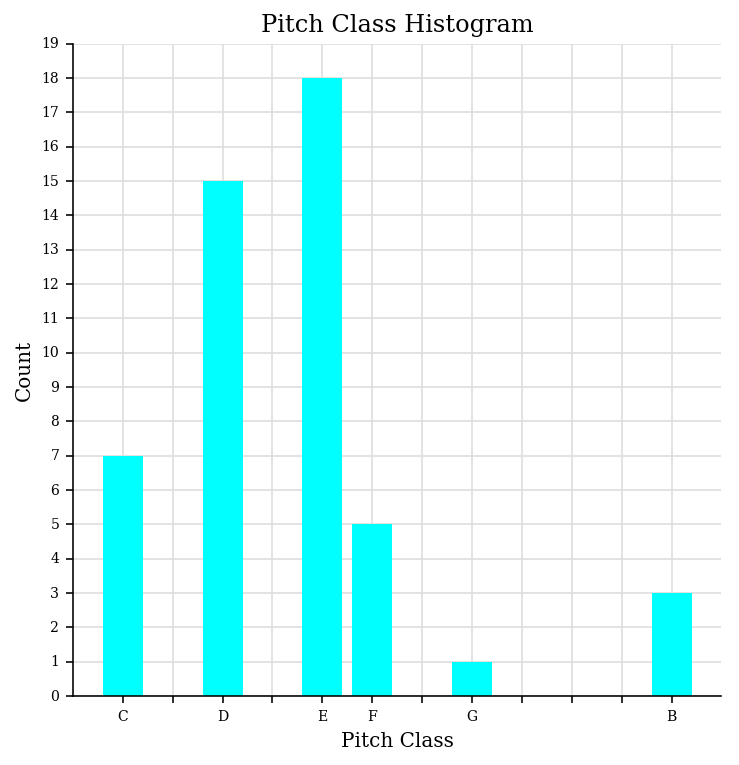

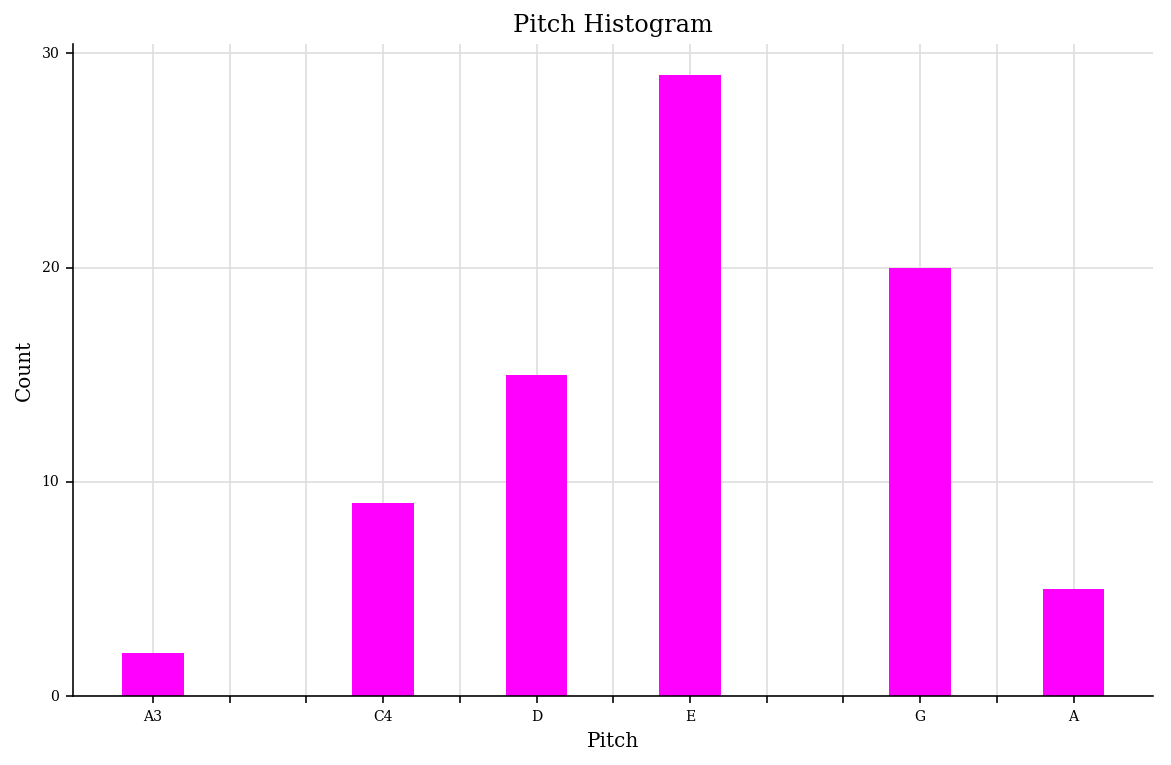

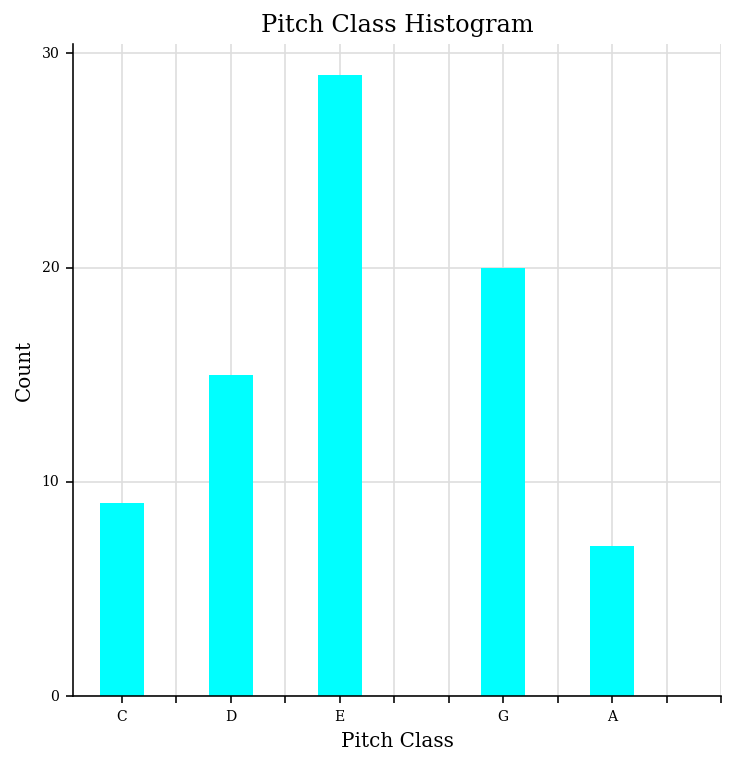

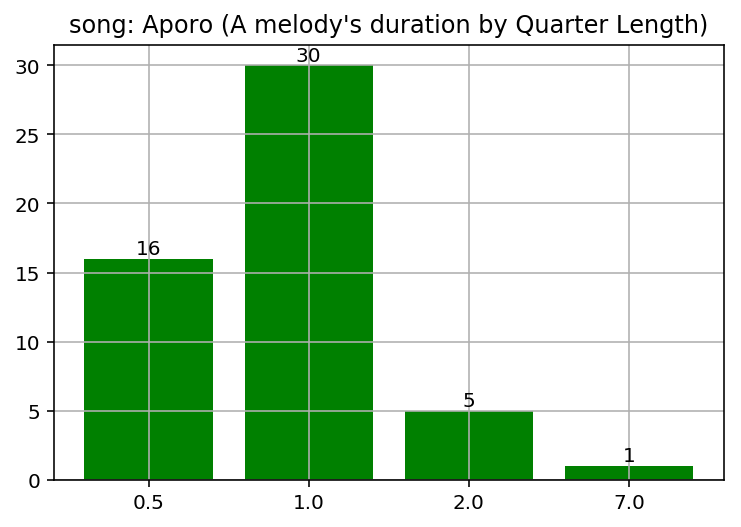

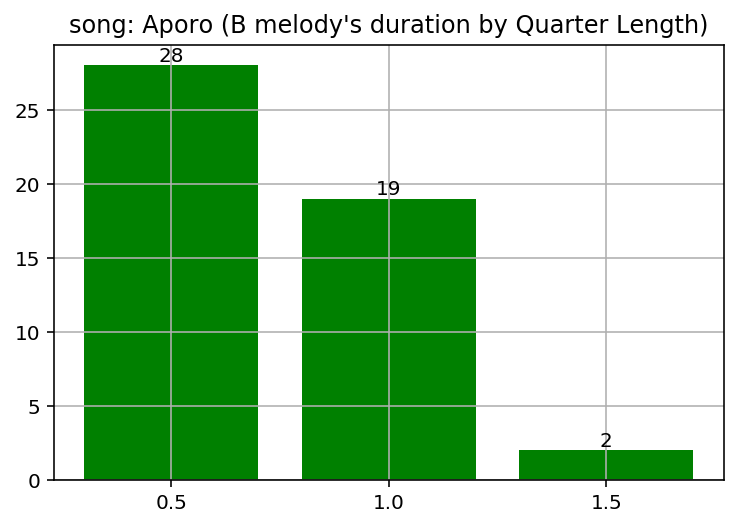

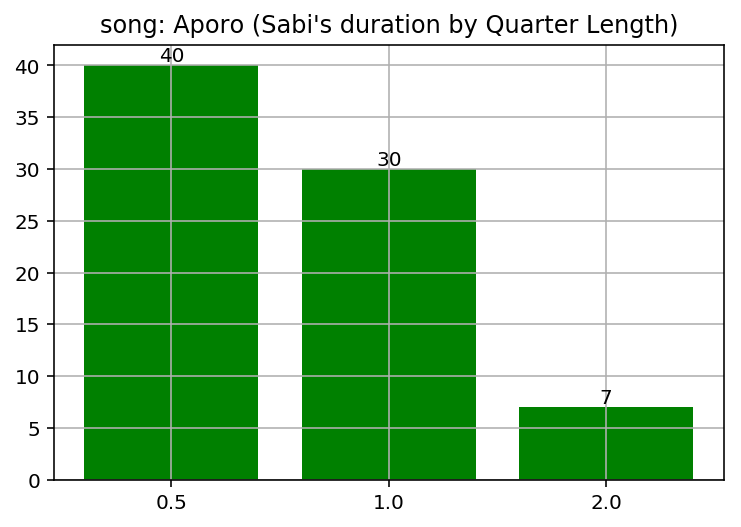

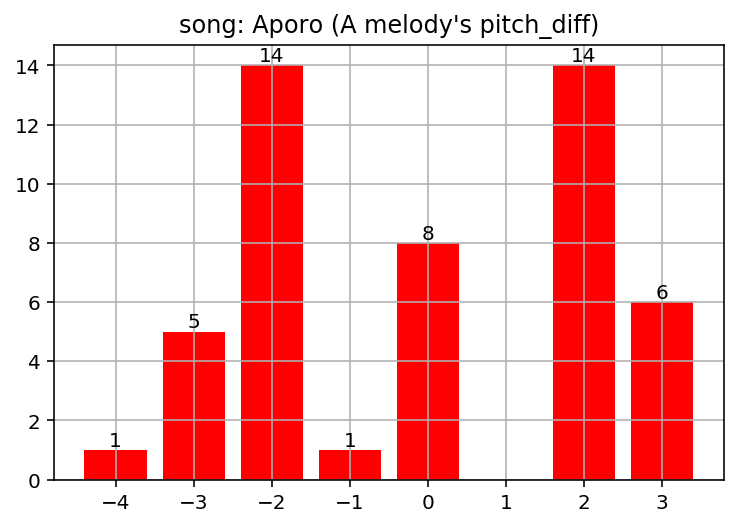

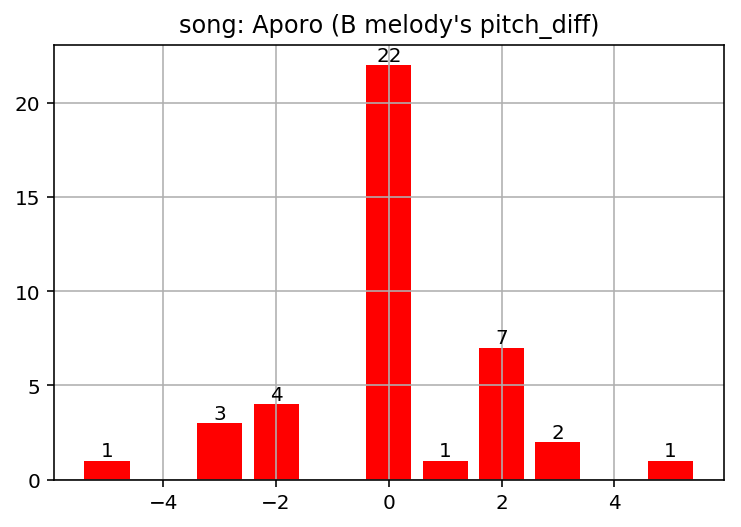

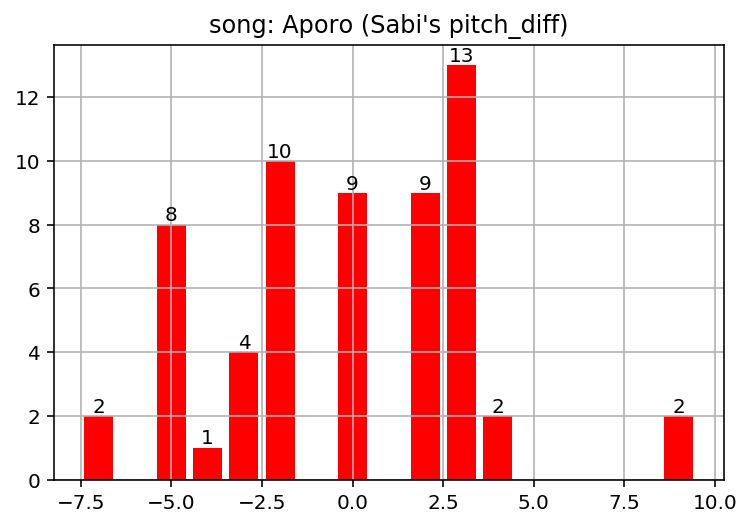

------------Guren No Yumiya-------------
-------A melodyの統計情報---------
調:F# major
-------B melodyの統計情報---------
調:C# major
-------Sabiの統計情報---------
調:c# minor


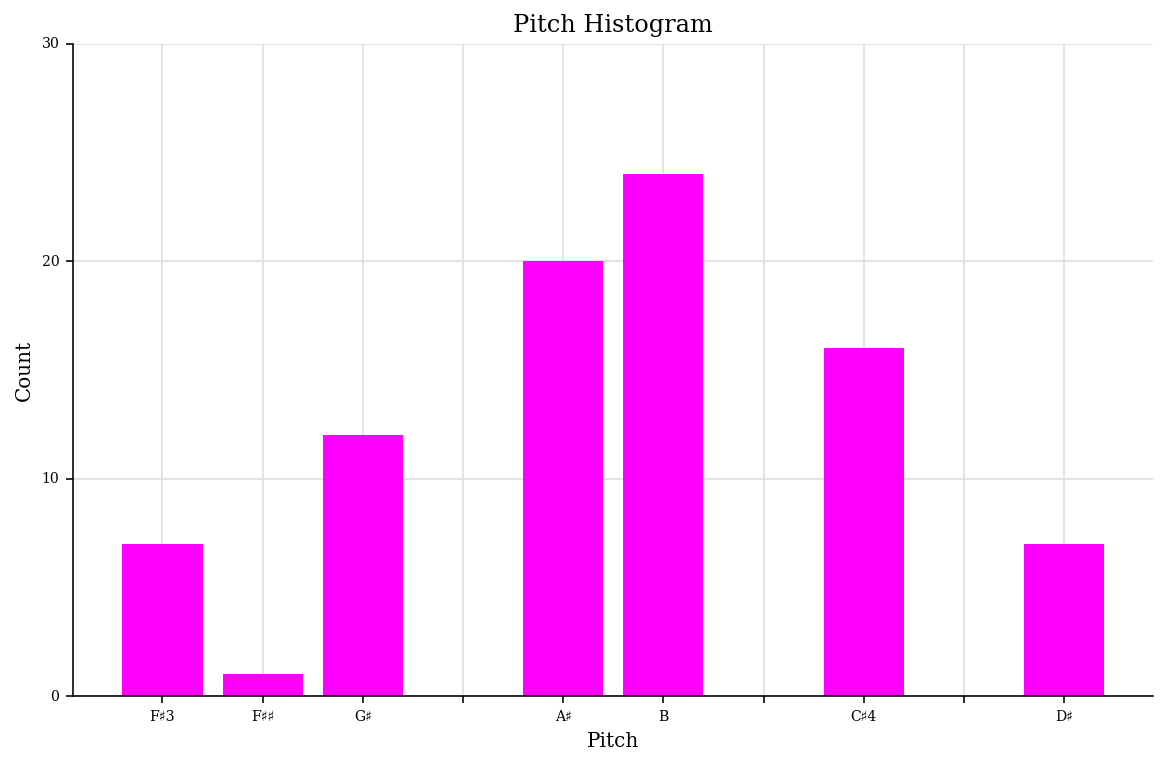

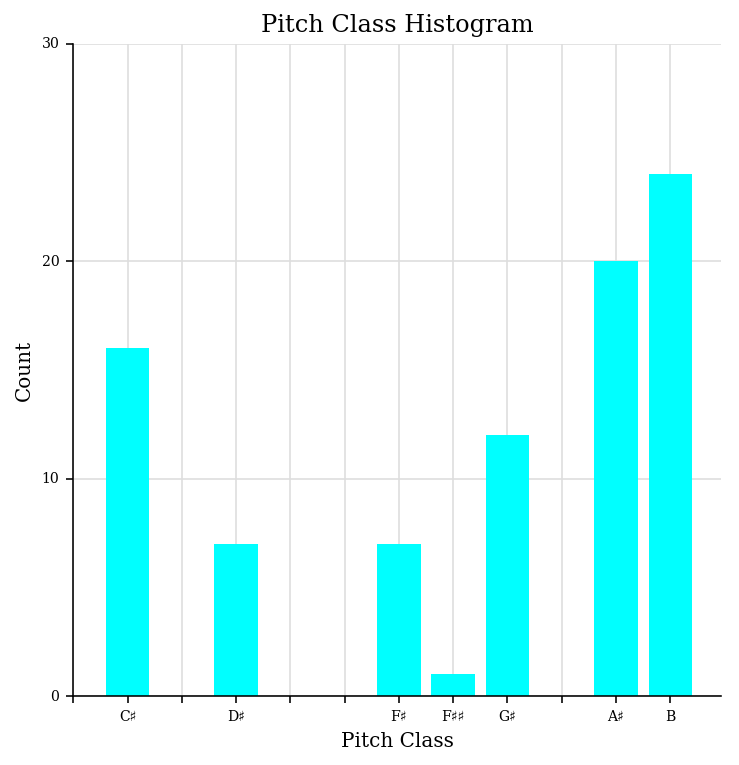

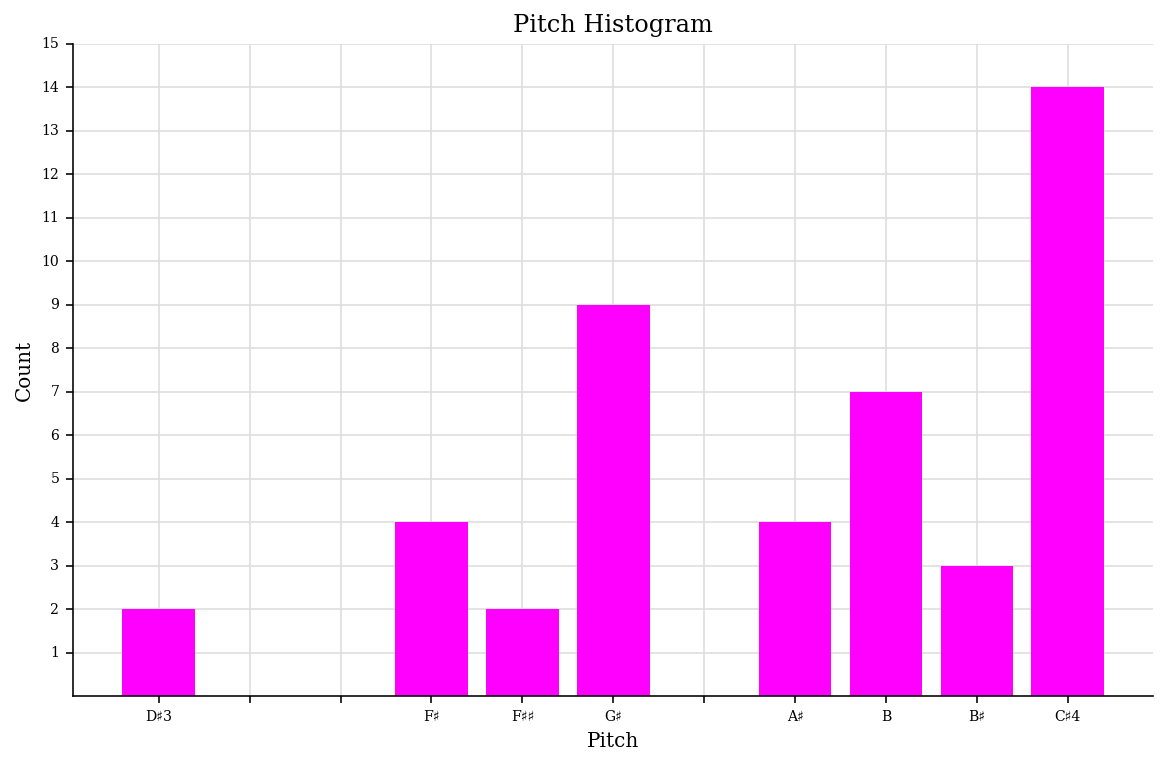

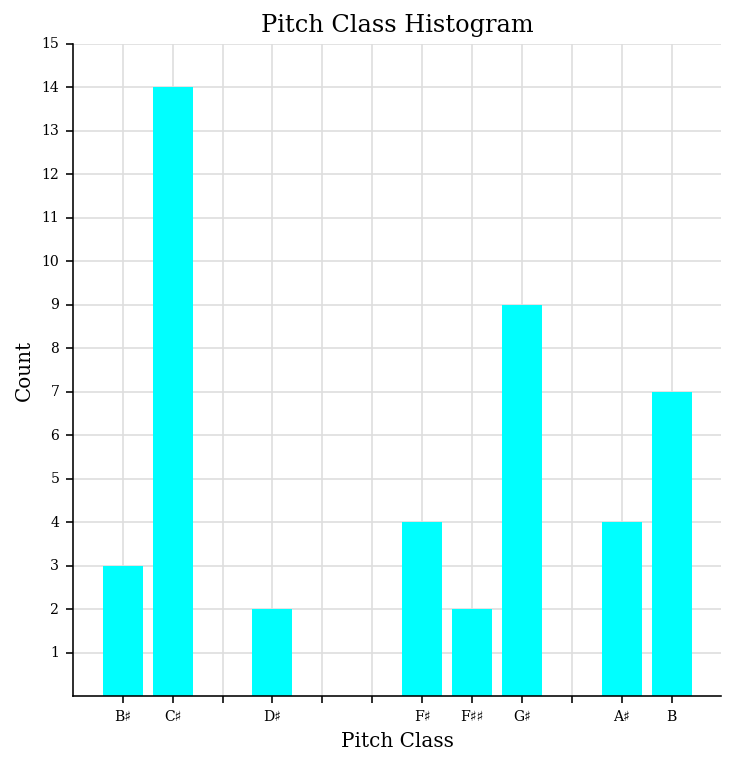

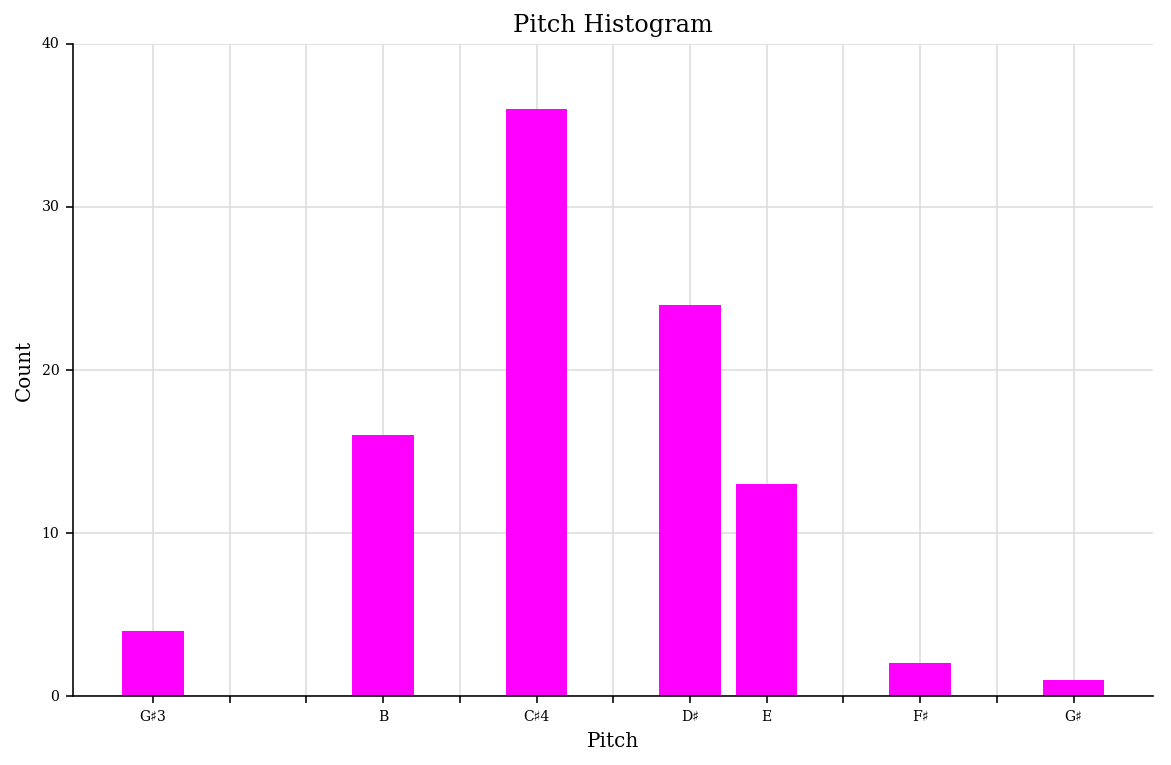

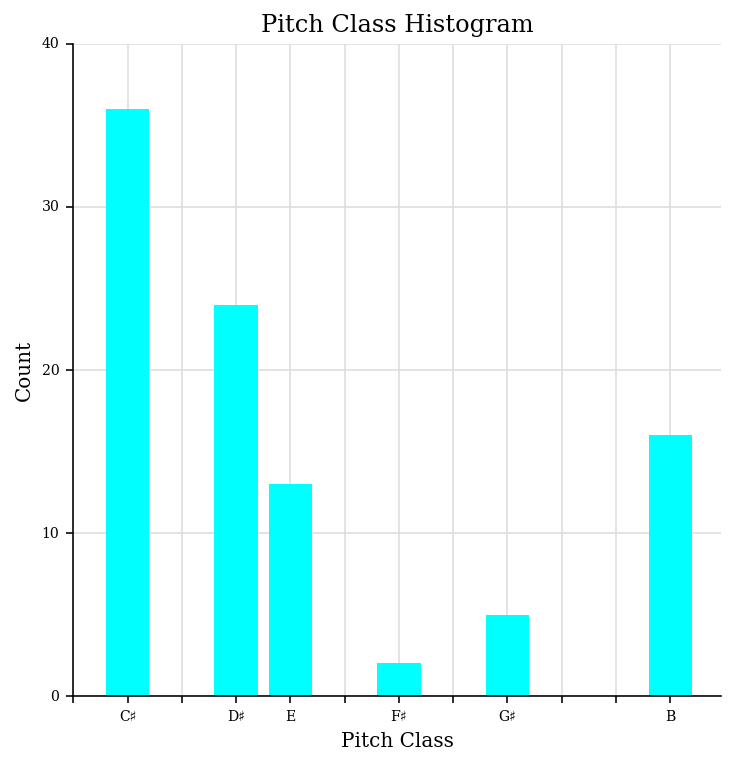

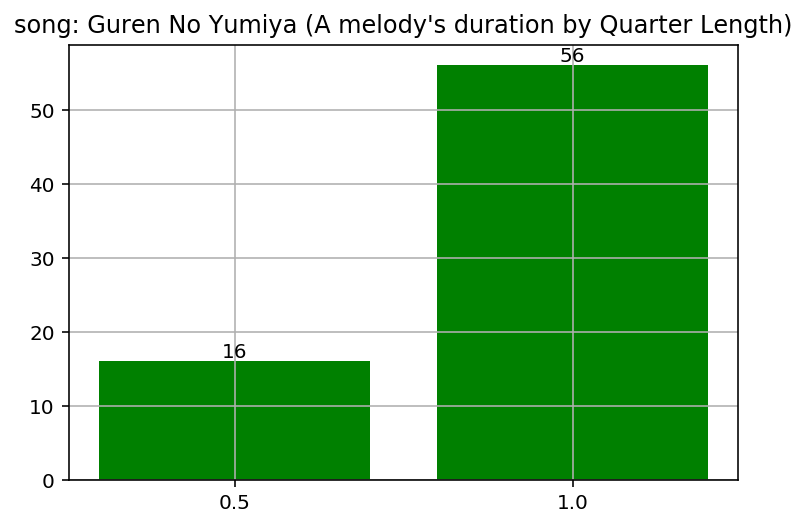

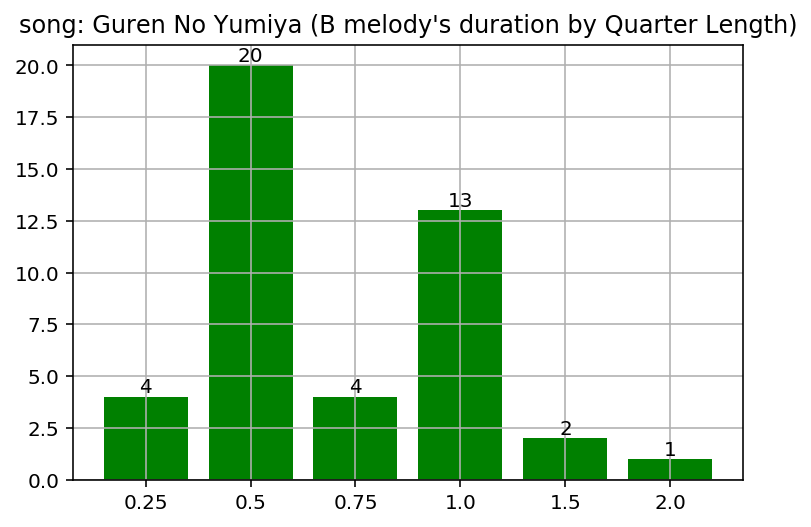

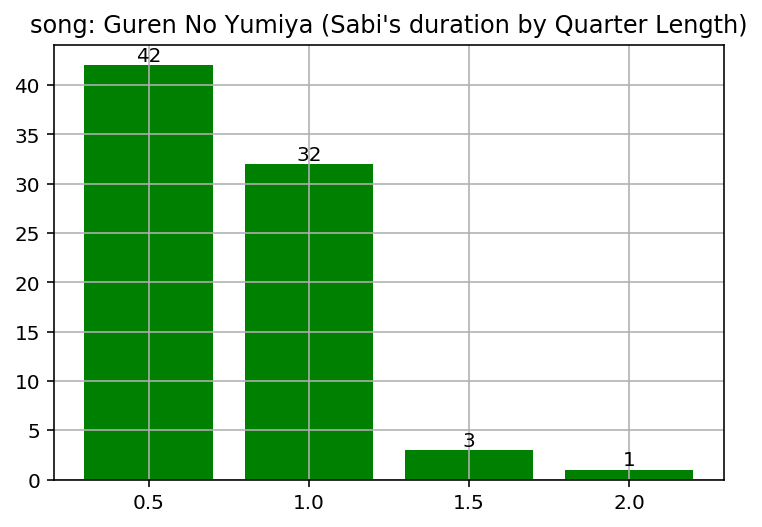

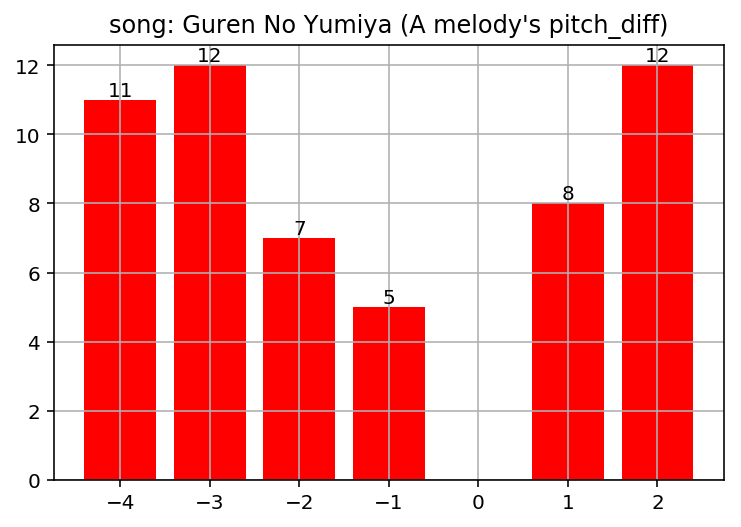

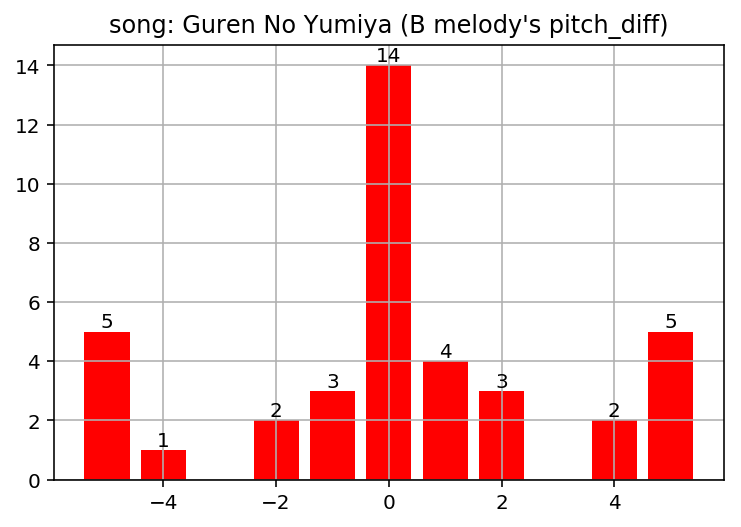

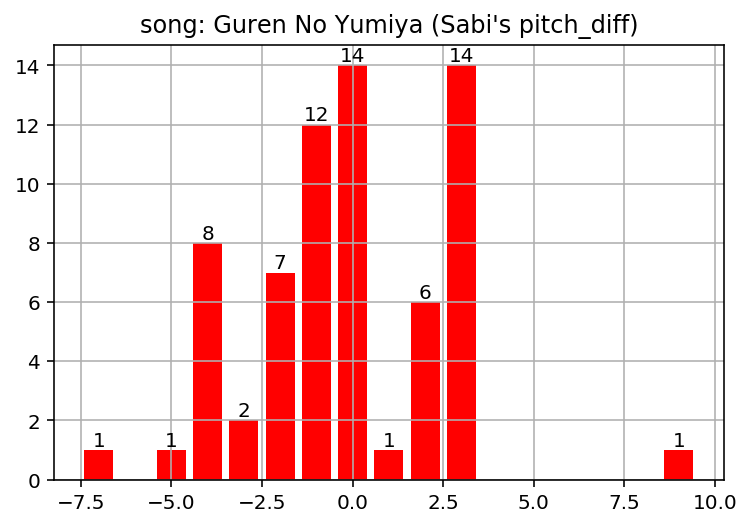

------------Konayuki-------------
-------A melodyの統計情報---------
調:D major
-------B melodyの統計情報---------
調:D major
-------Sabiの統計情報---------
調:D major


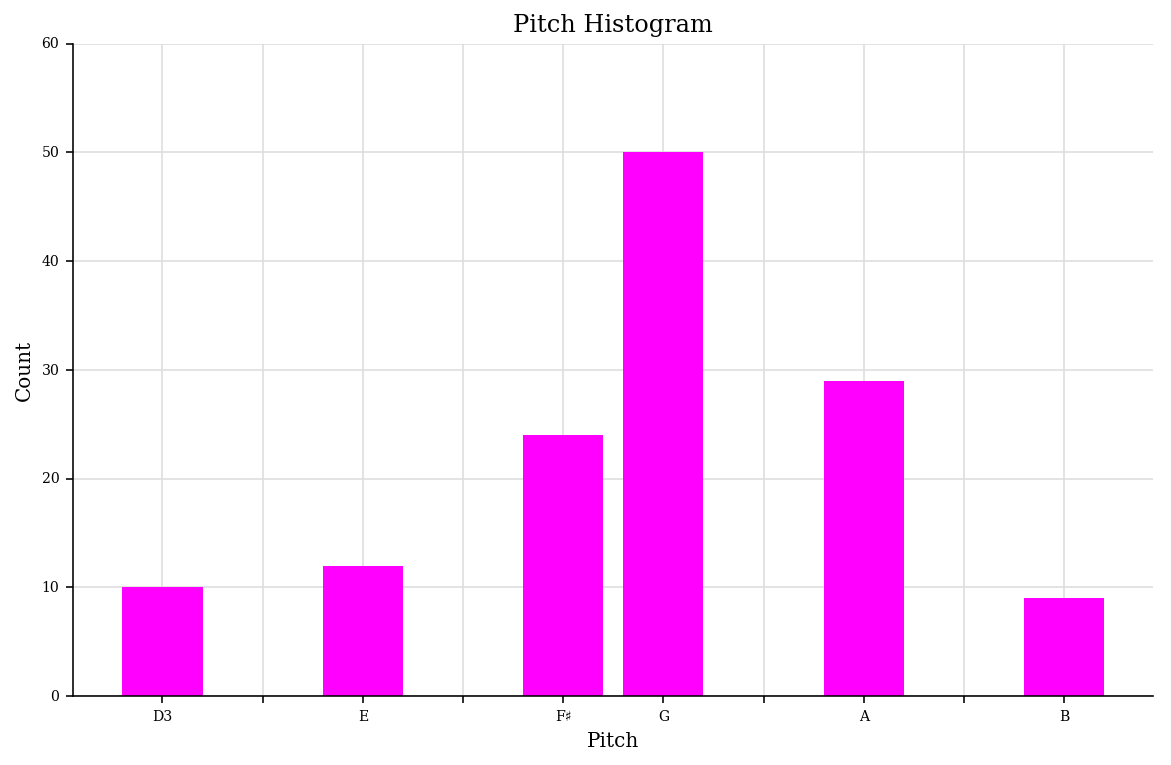

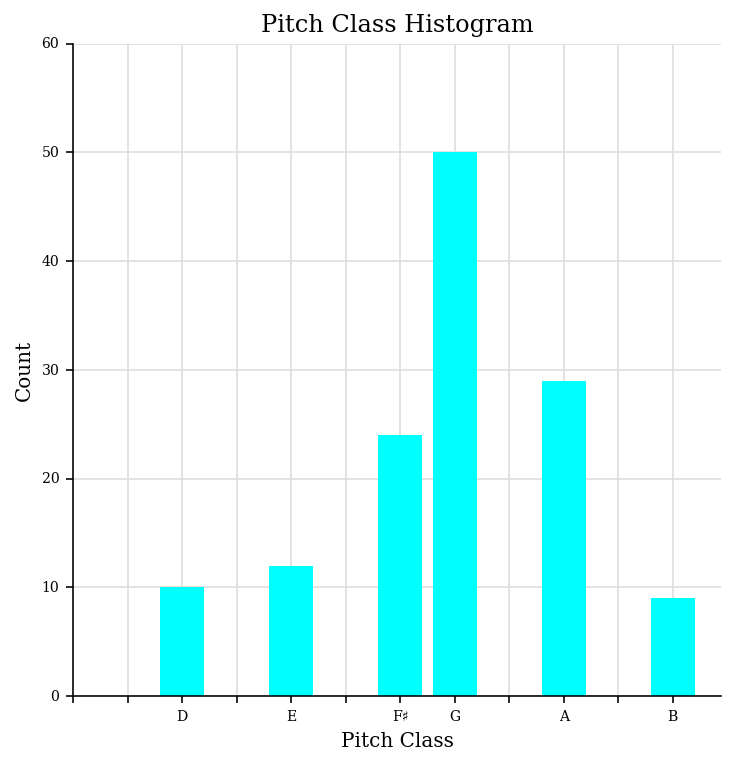

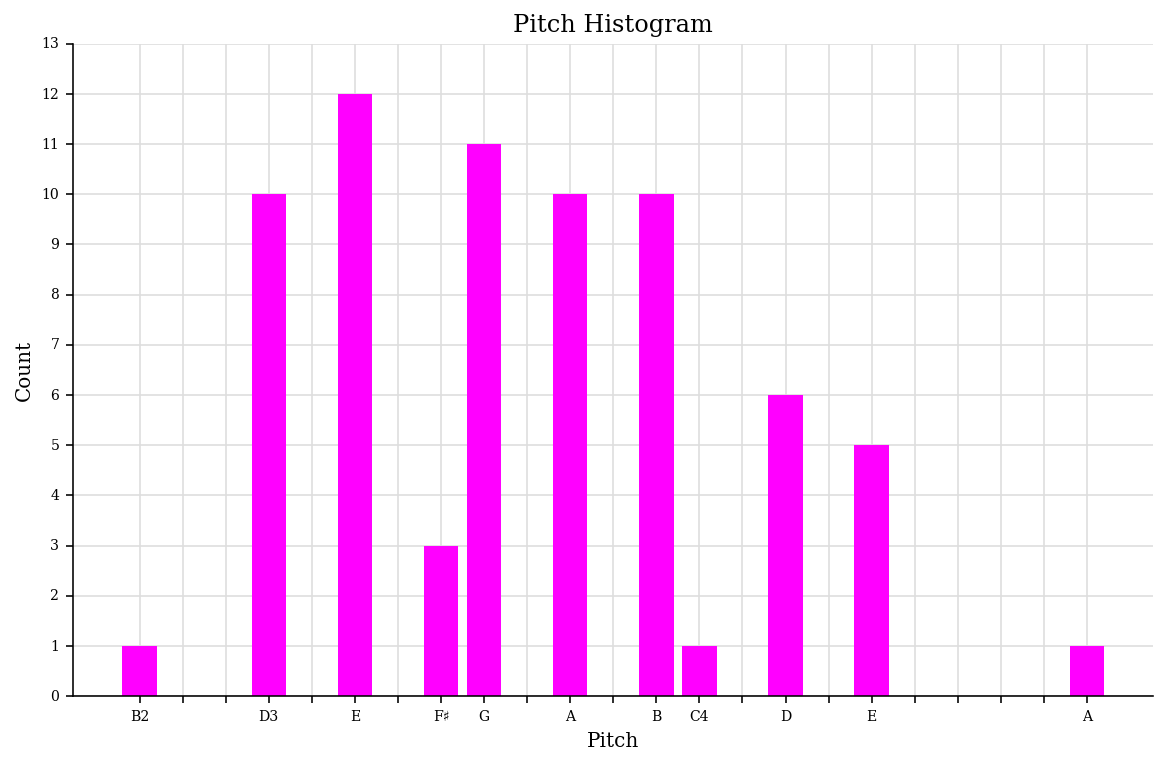

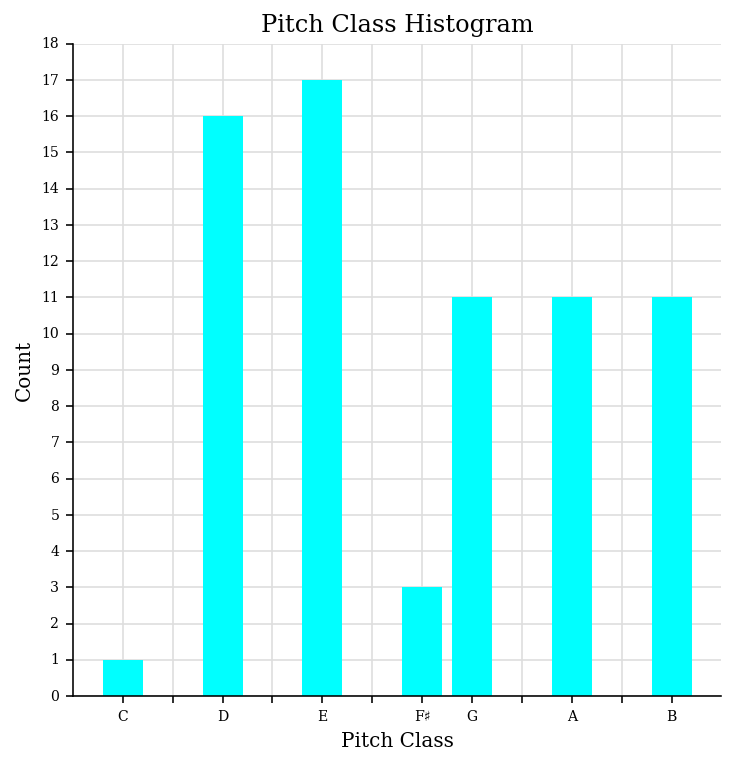

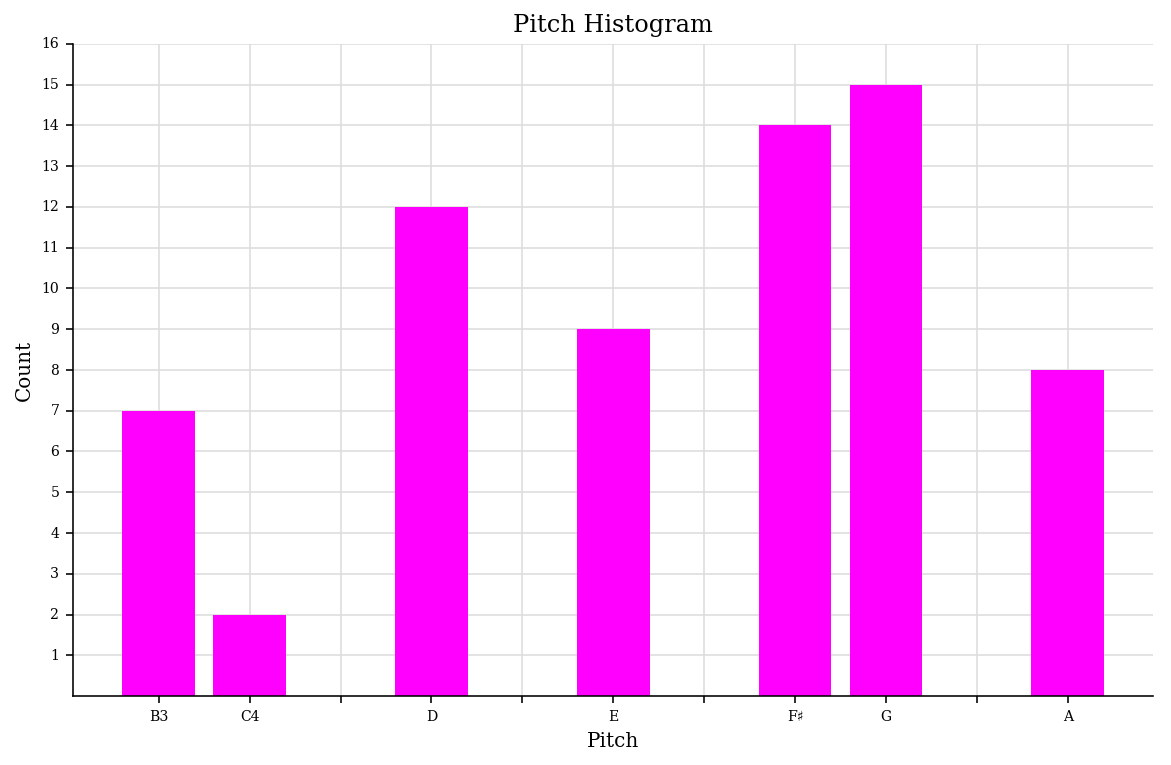

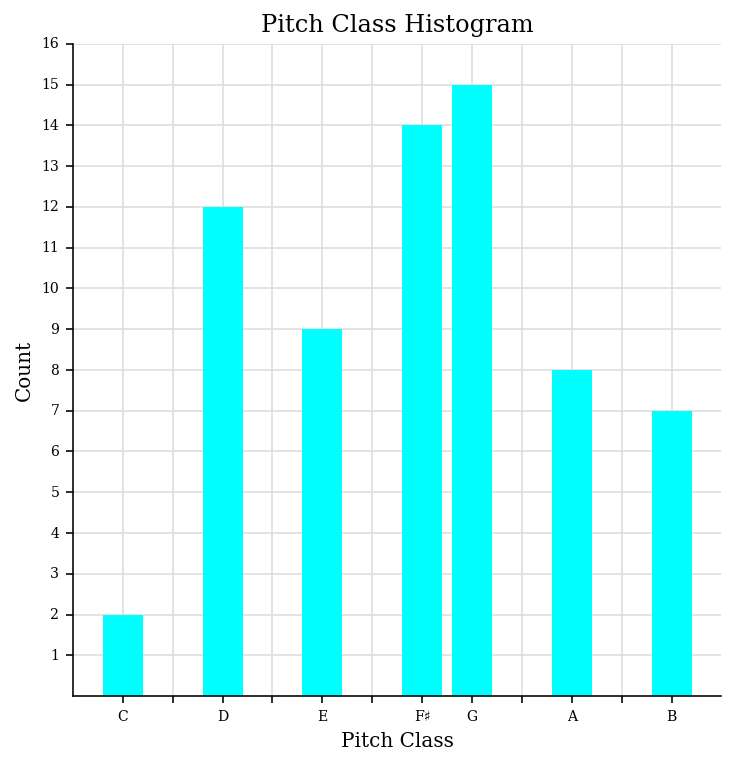

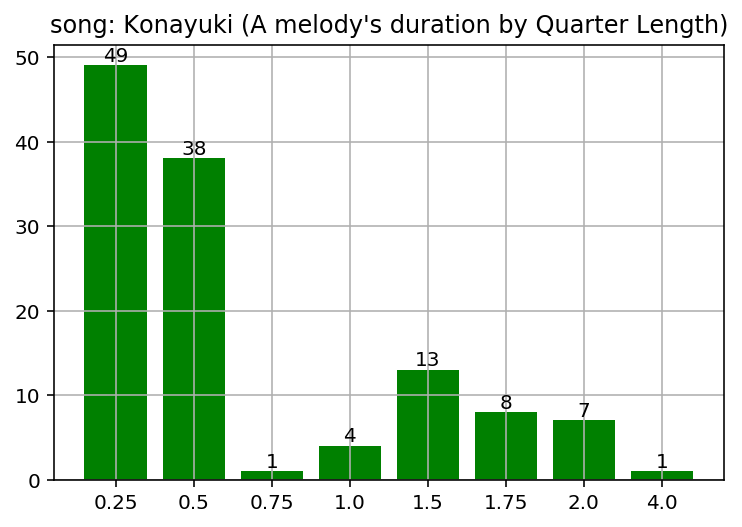

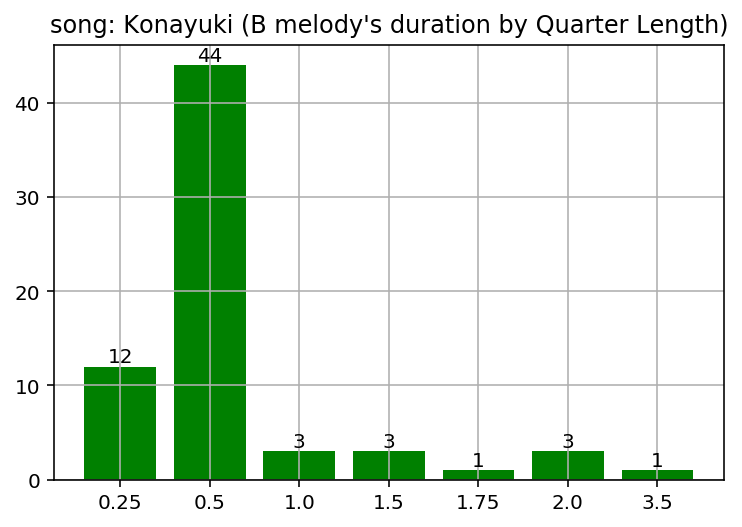

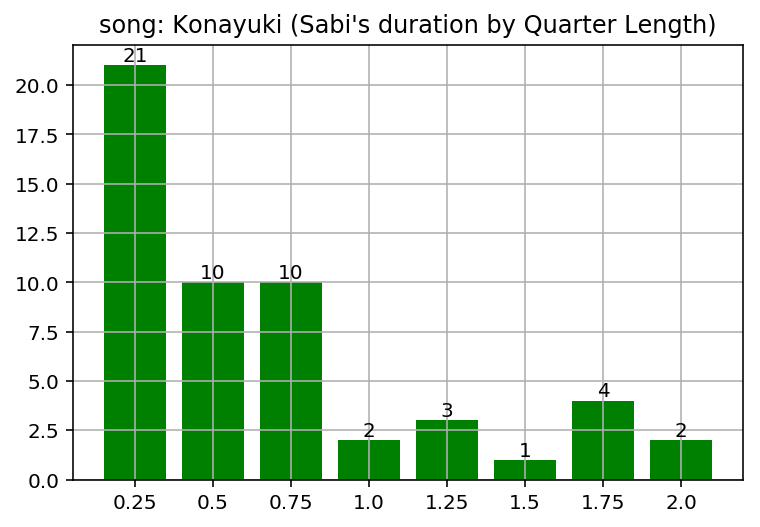

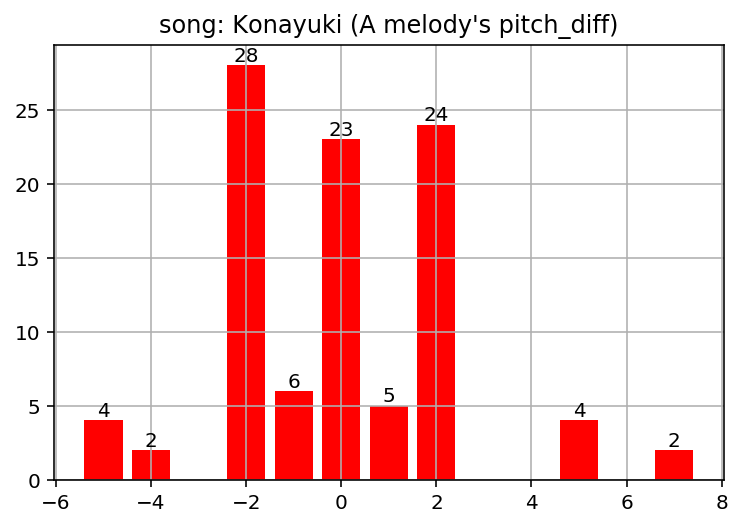

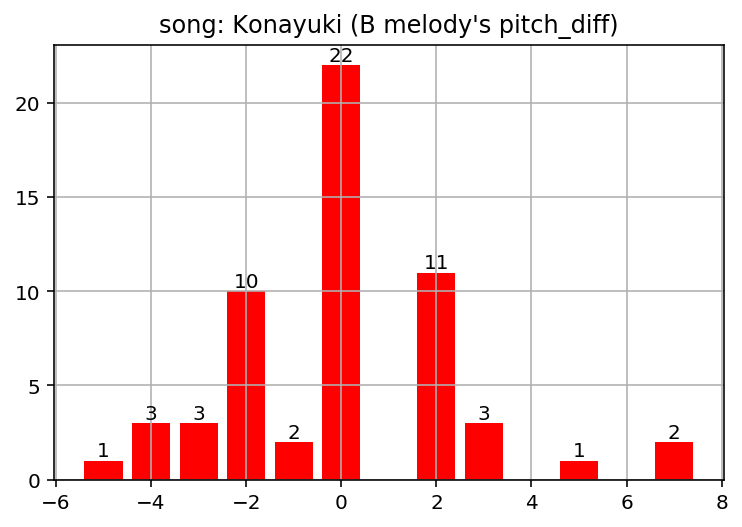

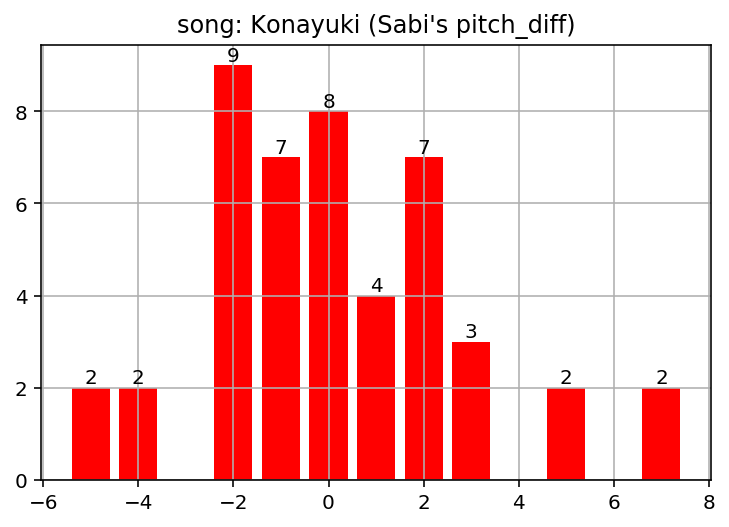

In [53]:
for sheets in analysis_corpus:
    sheets.show_key()
    sheets.counting_pitch()
    plt.figure()
    sheets.counting_duration()
    plt.figure()
    sheets.plot_pitch_diff()
    